In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import date
import holidays
import matplotlib.pyplot as plt
plt.style.use("bmh")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
import graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from itertools import chain, combinations
from tqdm.notebook import tqdm

## Import 

In [2]:
df_bonn = pd.read_pickle("data/df_bonn.pickle")
df_weather_bonn = pd.read_pickle("data/df_weather_bonn.pickle")
df_essen = pd.read_pickle("data/df_essen.pickle")
df_weather_essen = pd.read_pickle("data/df_weather_essen.pickle")

---

## Feature Selection

Demand on a given day $:=$ number of bike rentals on that day 

In [3]:
# Add holiday, semester and school columns
holiday=holidays.Germany(years=[2019],prov='NW')

def isHoliday(day):
    return int(day in holiday)

# Adding days of lecture (only weekdays and no holidays)
def isSemester(day):
    isSemester = ((date(2019,  4, 1) <= day < date(2019,  6, 10) or 
                  date(2019,  6, 15) <= day <= date(2019,  7, 12) or 
                  date(2019,  2, 1) == day) and 
                  day.weekday() < 5 and
                  day not in holiday)
    return int(isSemester)

# Adding days of school (only weekdays and no holidays)
def isSchool(day):
    isSchool = ((day < date(2019,  4, 15) or 
                day > date(2019,  4, 27)) and 
                date(2019,  6, 11) != day and
                day.weekday() < 5 and
                day not in holiday)
    return int(isSchool)

# Adding Karneval (Weiberfastnacht to Aschermittwoch)
def isKarneval(day):
    isKarneval = (date(2019,  2, 28) <= day <= date(2019,  3, 6))
    return int(isKarneval)

In [4]:
df_bonn["day"] = df_bonn["timestamp"].apply(lambda row: row.date())
df_bonn = df_bonn.drop(["timestamp"], axis=1)
df_demand_bonn = pd.DataFrame(df_bonn.groupby(["day"]).count()["b_number"])
df_demand_bonn = df_demand_bonn.rename(columns={"b_number": "demand"}) 
df_demand_bonn["isHoliday"] = df_demand_bonn.index.map(isHoliday)
df_demand_bonn["isWeekend"] = df_demand_bonn.index.map(lambda row: row.weekday()>=5).astype(int)
df_demand_bonn["isSemester"] = df_demand_bonn.index.map(isSemester)
df_demand_bonn["isSchool"] = df_demand_bonn.index.map(isSchool)
df_demand_bonn["isKarneval"] = df_demand_bonn.index.map(isKarneval)
df_demand_bonn

demand  isHoliday  isWeekend  isSemester  isSchool  isKarneval
day                                                                       
2019-02-01     904          0          0           1         1           0
2019-02-02     682          0          1           0         0           0
2019-02-03     624          0          1           0         0           0
2019-02-04     837          0          0           0         1           0
2019-02-05    1012          0          0           0         1           0
...            ...        ...        ...         ...       ...         ...
2019-06-26    3625          0          0           1         1           0
2019-06-27    3829          0          0           1         1           0
2019-06-28    4259          0          0           1         1           0
2019-06-29    3275          0          1           0         0           0
2019-06-30    2476          0          1           0         0           0

[147 rows x 6 columns]

In [5]:
df_essen["day"] = df_essen["timestamp"].apply(lambda row: row.date())
df_essen = df_essen.drop(["timestamp"], axis=1)
df_demand_essen = pd.DataFrame(df_essen.groupby(["day"]).count()["b_number"])
df_demand_essen = df_demand_essen.rename(columns={"b_number": "demand"}) 
df_demand_essen["isHoliday"] = df_demand_essen.index.map(isHoliday)
df_demand_essen["isWeekend"] = df_demand_essen.index.map(lambda row: row.weekday()>=5).astype(int)
df_demand_essen["isSemester"] = df_demand_essen.index.map(isSemester)
df_demand_essen["isSchool"] = df_demand_essen.index.map(isSchool)
df_demand_essen["isKarneval"] = df_demand_essen.index.map(isKarneval)
df_demand_essen

demand  isHoliday  isWeekend  isSemester  isSchool  isKarneval
day                                                                       
2019-02-01      57          0          0           1         1           0
2019-02-02      30          0          1           0         0           0
2019-02-03      29          0          1           0         0           0
2019-02-04      49          0          0           0         1           0
2019-02-05      60          0          0           0         1           0
...            ...        ...        ...         ...       ...         ...
2019-06-26     231          0          0           1         1           0
2019-06-27     272          0          0           1         1           0
2019-06-28     317          0          0           1         1           0
2019-06-29     174          0          1           0         0           0
2019-06-30     103          0          1           0         0           0

[147 rows x 6 columns]

---

### Weighting the weather data

Instead of simply aggregating each group of the dataframe of each city by `max()` or `avg()`, we use a weighted average:   
We group the weather dataframes by date and each of them has entries by hour, so each group contains data from multiple hours of that day. Each hour's value is weighted by the normalized bike rental activity of that hour. This means we put more weight on those hours of the day where bikes are generally more likely to be rented.

In [6]:
# Weather formatting
df_weather_bonn["day"] = df_weather_bonn["timestamp"].apply(lambda row: row.date())
df_weather_essen["day"] = df_weather_essen["timestamp"].apply(lambda row: row.date())

# WAVG: weighted AVG, where the weights are given by bike rental activity in each hour on an average day
weighting_bonn = df_bonn.groupby(["hour"]).count()["b_number"]
weighting_bonn = weighting_bonn/weighting_bonn.sum() # normalize to get a probability vector
weighting_essen = df_essen.groupby(["hour"]).count()["b_number"]
weighting_essen = weighting_essen/weighting_essen.sum() # normalize to get a probability vector

def weighted_average_bonn(group):
    return np.dot(group, weighting_bonn)

def weighted_average_essen(group):
    return np.dot(group, weighting_essen)

In [7]:
df_weather_bonn_wavg = df_weather_bonn.groupby(["day"]).agg(weighted_average_bonn)
df_weather_bonn_wavg = df_weather_bonn_wavg.rename(columns={c: f"WAVG({c})" for c in df_weather_bonn.columns})
df_weather_bonn_wavg = df_weather_bonn_wavg.drop(["WAVG(timestamp)"], axis=1)
df_weather_bonn_wavg 

WAVG(temperature_2m)  WAVG(dew_point_temperature_2m)  \
day                                                                
2019-02-01              2.589283                        0.190040   
2019-02-02              1.707427                        1.362507   
2019-02-03              2.170311                       -0.746181   
2019-02-04              2.497601                       -3.046916   
2019-02-05              3.547125                        1.223116   
...                          ...                             ...   
2019-06-26             28.361665                       17.564708   
2019-06-27             23.384853                        9.162896   
2019-06-28             23.014943                        9.474918   
2019-06-29             27.741437                       10.377776   
2019-06-30             27.836808                       16.056995   

            WAVG(relative_humidity)  WAVG(precipitation)  \
day                                                        
2019-02-01                84.655778             0.000537   
2019-02-02                97.521537             0.099593   
2019-02-03                81.691930             0.000000   
2019-02-04                67.962935             0.000000   
2019-02-05                84.980757             0.023813   
...                             ...                  ...   
2019-06-26                53.397946             0.000000   
2019-06-27                43.588095             0.000000   
2019-06-28                44.889360             0.000000   
2019-06-29                36.495337             0.000000   
2019-06-30                49.796694             0.000000   

            WAVG(has_precipitated)  WAVG(wind_velocity_10m)  \
day                                                           
2019-02-01                0.114506                 3.038463   
2019-02-02                0.870144                 1.851419   
2019-02-03                0.291645                 2.416769   
2019-02-04                0.089857                 3.977812   
2019-02-05                0.626654                 1.825829   
...                            ...                      ...   
2019-06-26                0.000000                 2.777642   
2019-06-27                0.000000                 3.073079   
2019-06-28                0.000000                 1.846362   
2019-06-29                0.000000                 2.476115   
2019-06-30                0.000000                 3.136759   

            WAVG(wind_direction_10m)  WAVG(mean_wind_speed_10m)  \
day                                                               
2019-02-01                124.923856                   3.207866   
2019-02-02                255.581138                   1.730363   
2019-02-03                301.408881                   2.574698   
2019-02-04                181.488745                   3.882295   
2019-02-05                162.644643                   1.833161   
...                              ...                        ...   
2019-06-26                309.156481                   2.717872   
2019-06-27                236.407469                   3.090089   
2019-06-28                241.325525                   1.815826   
2019-06-29                101.899238                   2.481449   
2019-06-30                276.905387                   3.016989   

            WAVG(mean_wind_direction_10m)  WAVG(air_pressure_station_level)  \
day                                                                           
2019-02-01                     129.995992                        971.119469   
2019-02-02                     237.622157                        979.431008   
2019-02-03                     306.407773                       1001.061444   
2019-02-04                     182.936981                       1007.202358   
2019-02-05                     164.391350                       1008.324046   
...                                   ...                               ...   
2019-06-26            

In [8]:
df_weather_essen_wavg = df_weather_essen.groupby(["day"]).agg(weighted_average_essen)
df_weather_essen_wavg = df_weather_essen_wavg.rename(columns={c: f"WAVG({c})" for c in df_weather_essen.columns})
df_weather_essen_wavg = df_weather_essen_wavg.drop(["WAVG(timestamp)"], axis=1)
df_weather_essen_wavg 

WAVG(temperature_2m)  WAVG(dew_point_temperature_2m)  \
day                                                                
2019-02-01              2.683164                       -0.400295   
2019-02-02              0.532974                       -0.603064   
2019-02-03              1.923608                       -1.470812   
2019-02-04              2.174682                       -3.438085   
2019-02-05              2.772528                        1.540757   
...                          ...                             ...   
2019-06-26             25.677072                       17.954211   
2019-06-27             20.462746                       10.403545   
2019-06-28             20.039355                        9.348817   
2019-06-29             27.438343                        9.887239   
2019-06-30             26.458117                       14.465990   

            WAVG(relative_humidity)  WAVG(precipitation)  \
day                                                        
2019-02-01                80.848372             0.046777   
2019-02-02                92.127370             0.670872   
2019-02-03                79.155059             0.000000   
2019-02-04                67.680672             0.000000   
2019-02-05                91.723530             0.017974   
...                             ...                  ...   
2019-06-26                63.280624             0.000000   
2019-06-27                54.699392             0.000000   
2019-06-28                52.606995             0.000000   
2019-06-29                36.463733             0.000000   
2019-06-30                47.954132             0.000000   

            WAVG(has_precipitated)  WAVG(wind_velocity_10m)  \
day                                                           
2019-02-01                0.230482                 3.095118   
2019-02-02                0.911214                 2.977361   
2019-02-03                0.000000                 2.432721   
2019-02-04                0.128875                 4.249907   
2019-02-05                0.170228                 2.650876   
...                            ...                      ...   
2019-06-26                0.000000                 3.344441   
2019-06-27                0.000000                 3.824685   
2019-06-28                0.000000                 3.215500   
2019-06-29                0.000000                 1.846199   
2019-06-30                0.000000                 3.668525   

            WAVG(wind_direction_10m)  WAVG(mean_wind_speed_10m)  \
day                                                               
2019-02-01                137.301511                   3.081340   
2019-02-02                 54.298441                   2.918799   
2019-02-03                308.121953                   2.419479   
2019-02-04                192.690664                   4.207247   
2019-02-05                202.853187                   2.613772   
...                              ...                        ...   
2019-06-26                231.906338                   3.264305   
2019-06-27                 85.601637                   3.806308   
2019-06-28                 51.835310                   3.354012   
2019-06-29                148.374165                   1.822206   
2019-06-30                259.647866                   3.578282   

            WAVG(mean_wind_direction_10m)  WAVG(air_pressure_station_level)  \
day                                                                           
2019-02-01                     140.552579                        971.989027   
2019-02-02                      44.114850                        980.884608   
2019-02-03                     313.163185                       1001.828357   
2019-02-04                     194.832360                       1007.154361   
2019-02-05                     205.229639                       1008.878421   
...                                   ...                               ...   
2019-06-26            

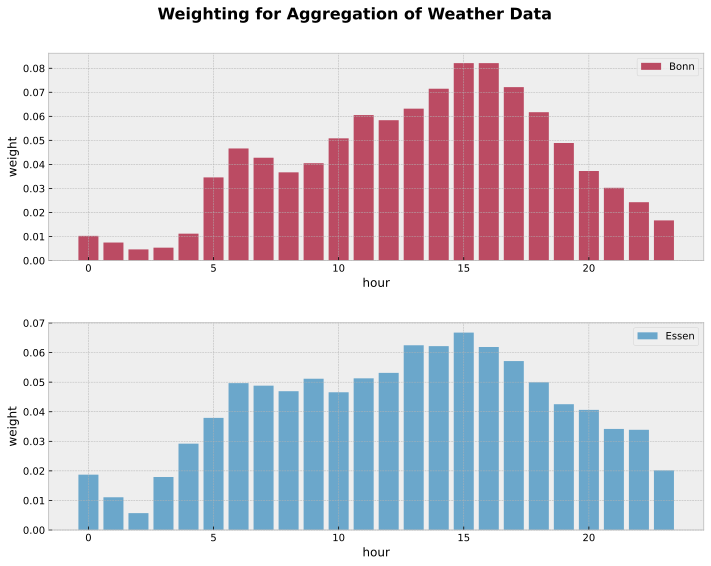

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 8))
# Bonn
ax1.bar(range(24), weighting_bonn, alpha=0.7, color='C1')
ax1.set_xlabel("hour")
ax1.set_ylabel("weight")
ax1.legend(['Bonn'])

# Essen
ax2.bar(range(24), weighting_essen, alpha=0.7)
ax2.set_xlabel("hour")
ax2.set_ylabel("weight")
ax2.legend(['Essen'])

fig.tight_layout()
fig.suptitle("Weighting for Aggregation of Weather Data", fontweight="bold", fontsize=16)
fig.subplots_adjust(top=0.9, hspace=0.3)

In [10]:
# Join demand and weather data (Bonn)
df_bonn = df_demand_bonn.join(df_weather_bonn_wavg, on="day", how="outer")
df_bonn = df_bonn[df_bonn.index.notna()] # remove entries where data is NaT
df_bonn = df_bonn.drop(["day"], axis=1)

# Join demand and weather data (Essen)
df_essen = df_demand_essen.join(df_weather_essen_wavg, on="day", how="outer")
df_essen = df_essen[df_essen.index.notna()] # remove entries where data is NaT
df_essen = df_essen.drop(["day"], axis=1)

---

### Feature selection criteria

To select suitable features for our regression models we first examined the correlation among the features (especially `demand`).

In [11]:
# Plot a simple linear regression between demand and every other feature
def plot_all_features(city):
    df = df_bonn if city=="Bonn" else df_essen
    for i, feature in enumerate(df_bonn.columns[1:]):
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title(f"{feature} vs Demand", fontsize=16, fontweight="bold", pad=20)
        ax.set_xlabel(feature)
        ax.set_ylabel("demand")
        ax.scatter(df[feature], df["demand"], marker="x", label="Observation on a specific day")
        
        # Simple linear regression
        df_dropped = df[[feature, "demand"]].dropna() 
        X = pd.DataFrame(df_dropped[feature])
        y = df_dropped["demand"]
        model = LinearRegression()
        model.fit(X, y)
        x_space = np.linspace(df[feature].min(), df[feature].max(), 100).reshape(100, 1)
        y_pred = model.predict(x_space)
        ax.plot(x_space, y_pred, c="red", label="Linear Regression")
        ax.legend(loc="lower right")

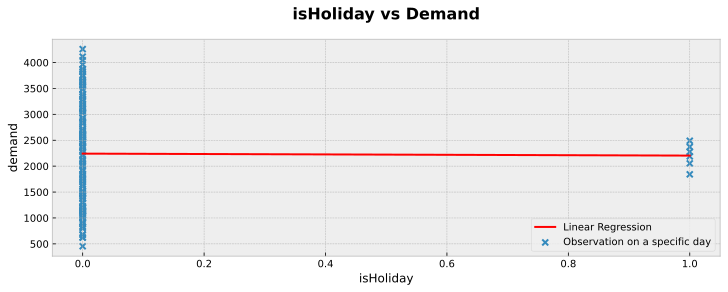

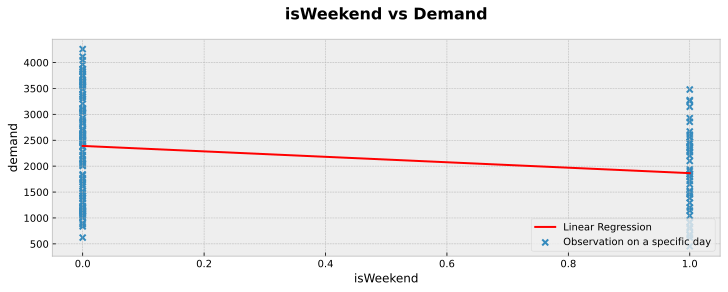

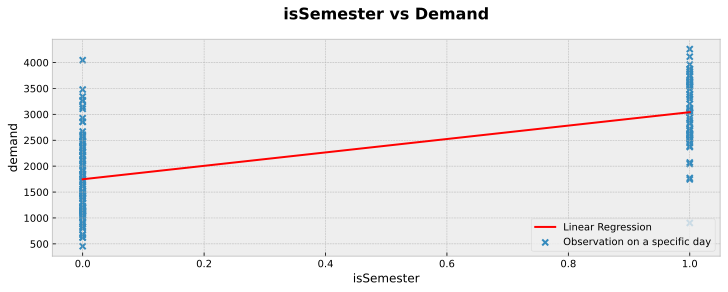

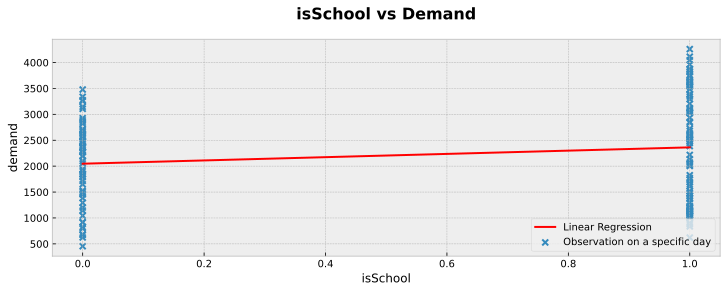

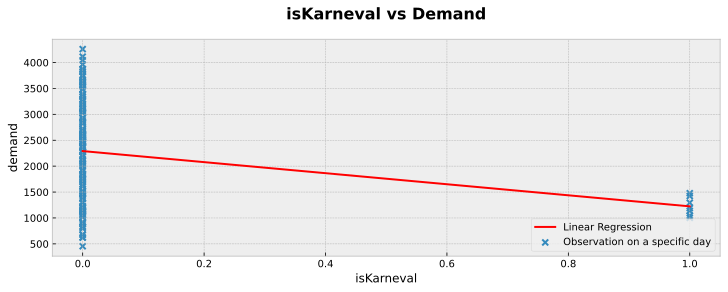

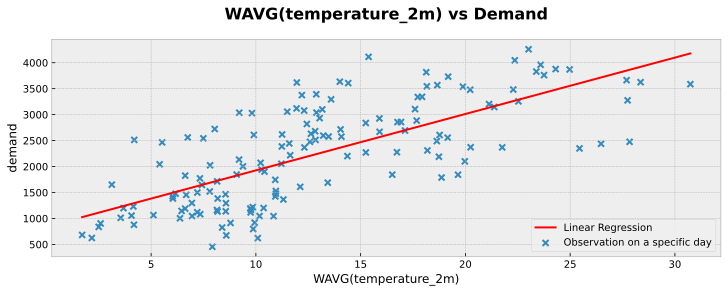

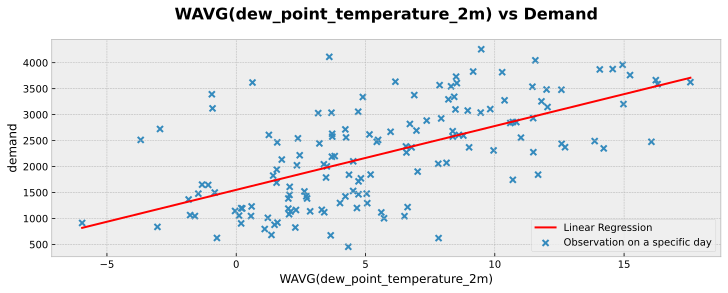

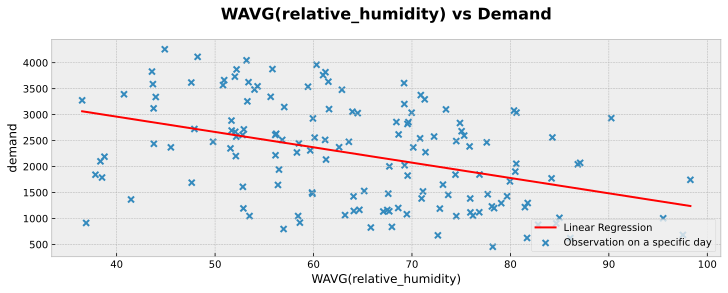

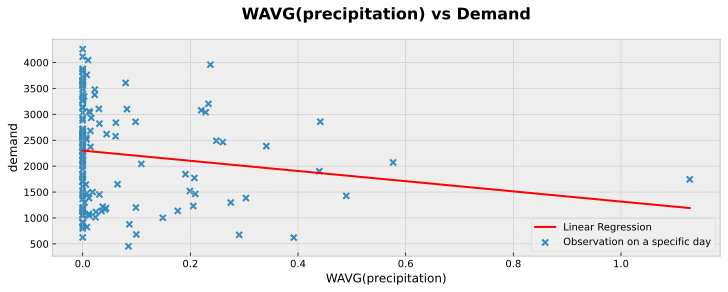

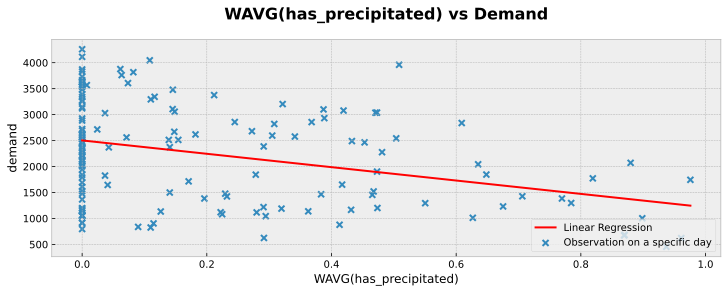

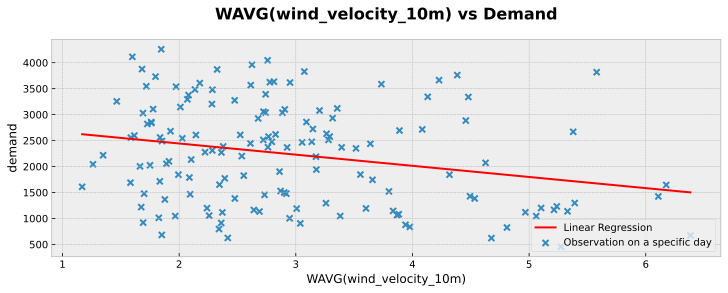

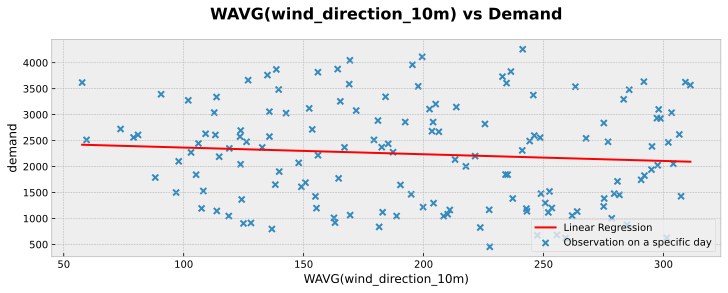

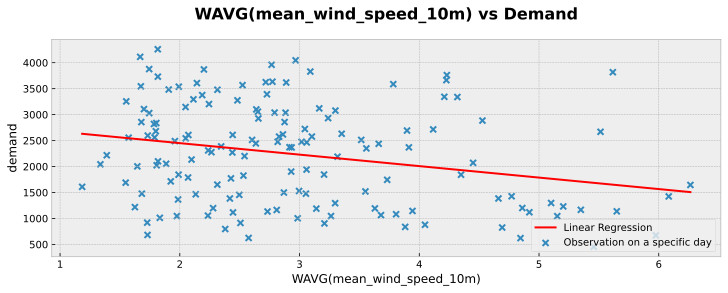

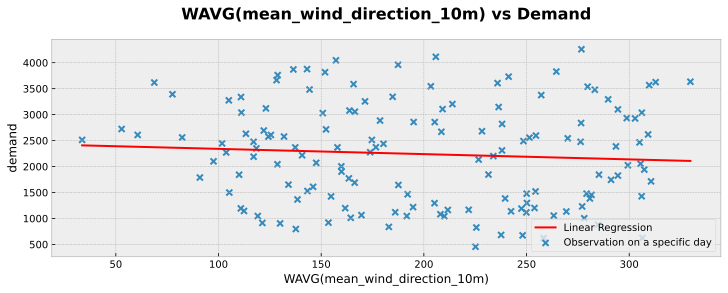

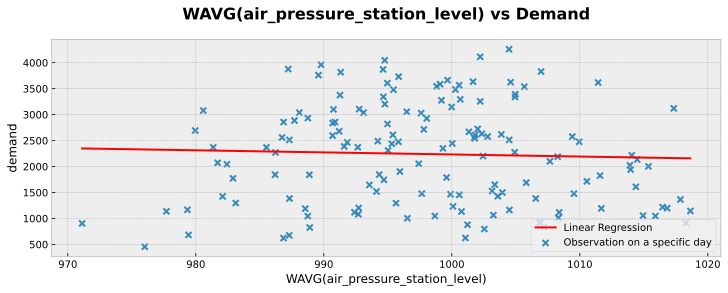

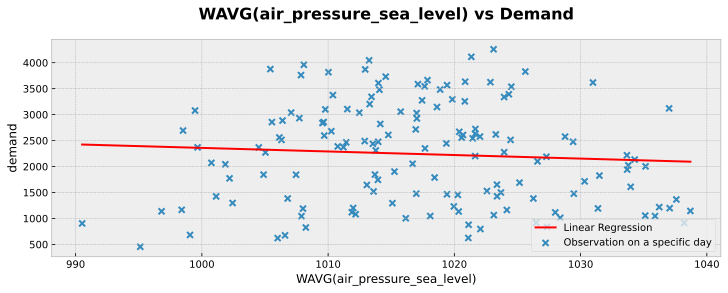

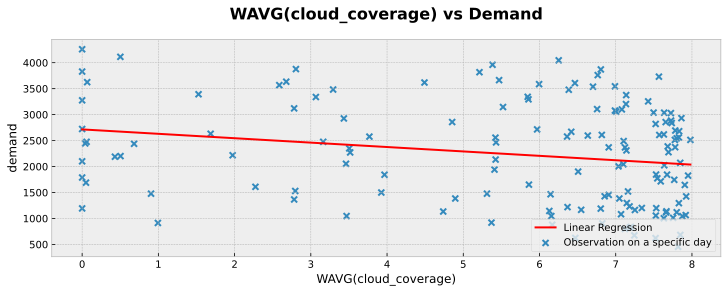

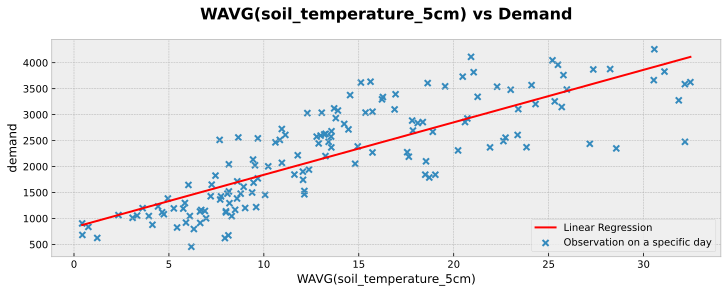

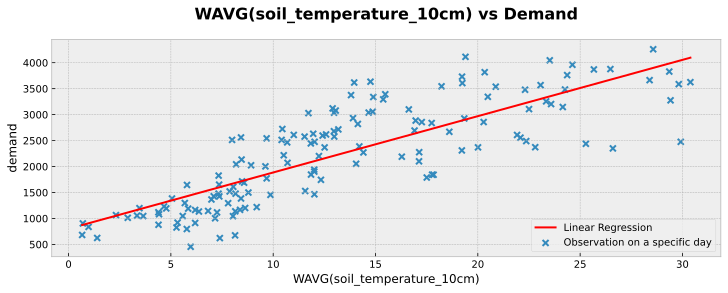

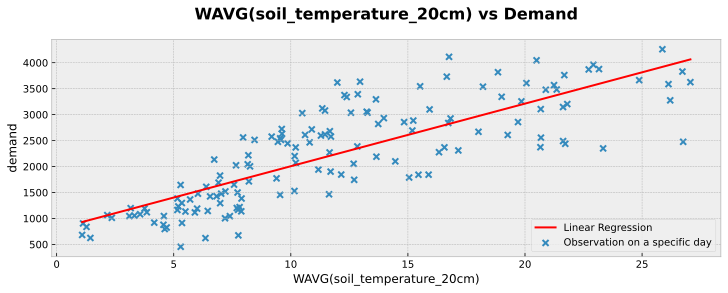

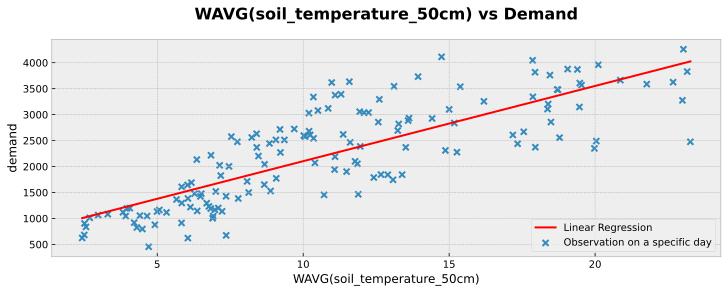

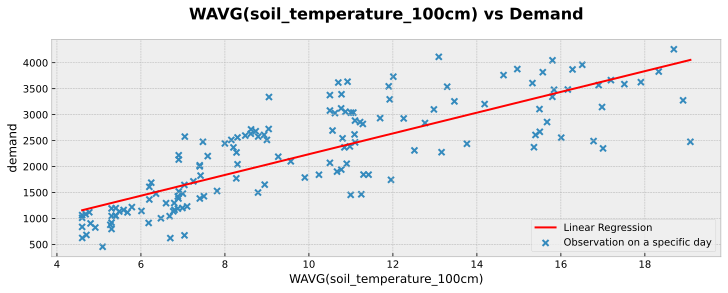

In [12]:
plot_all_features("Bonn")

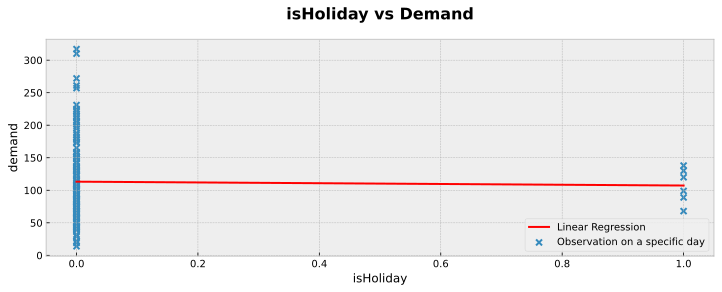

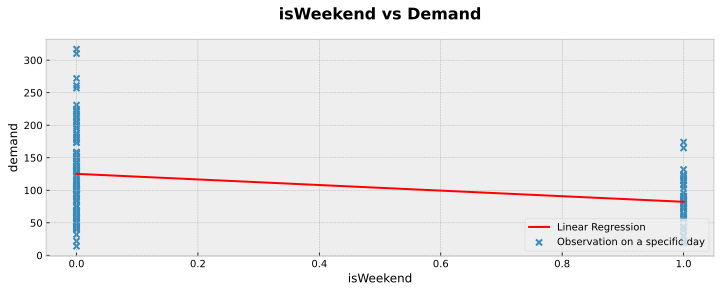

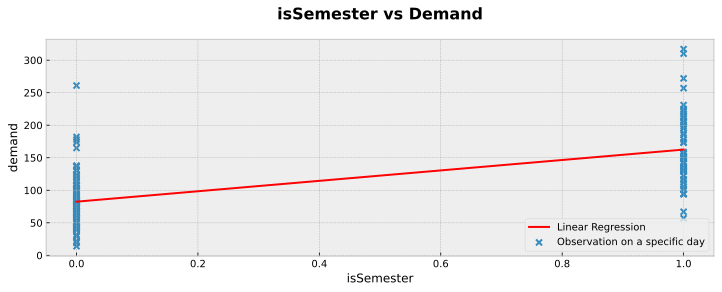

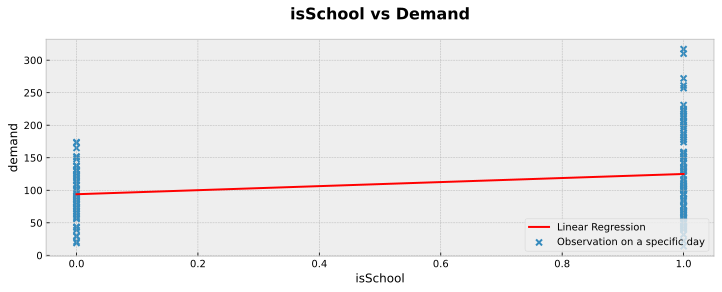

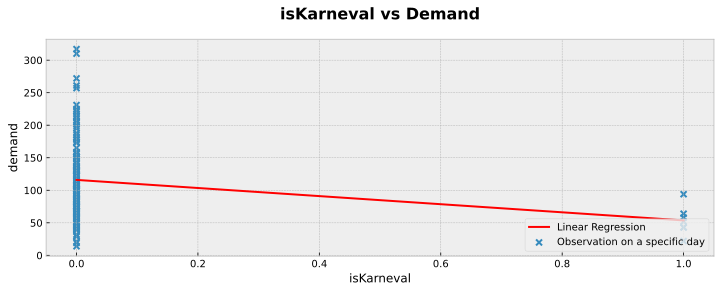

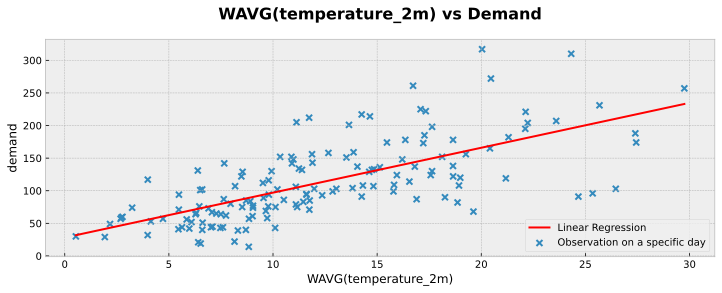

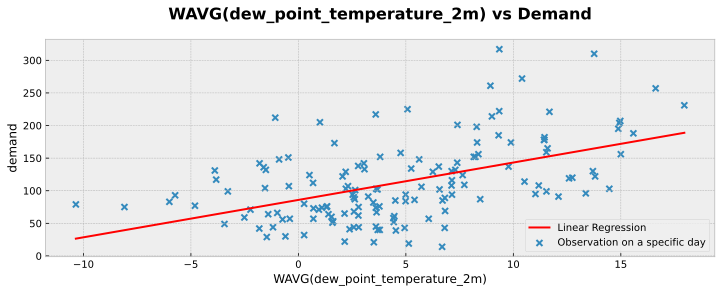

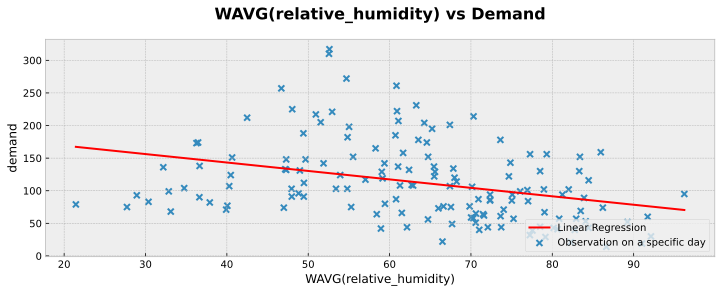

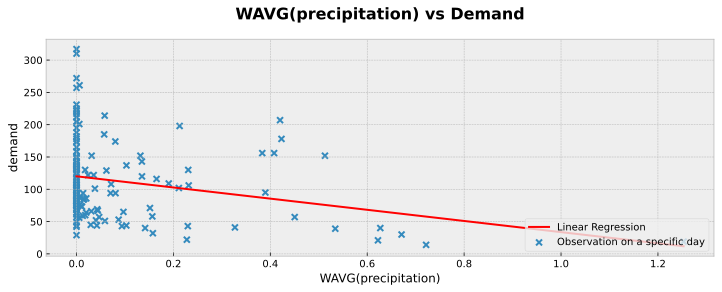

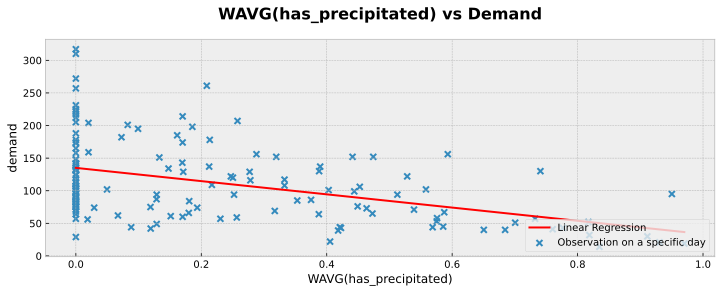

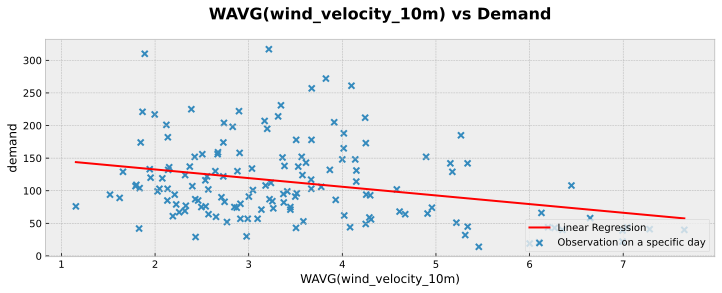

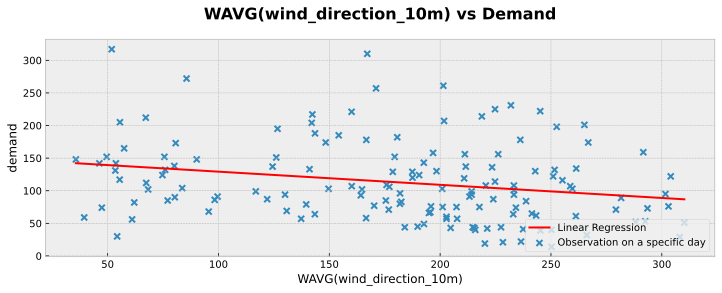

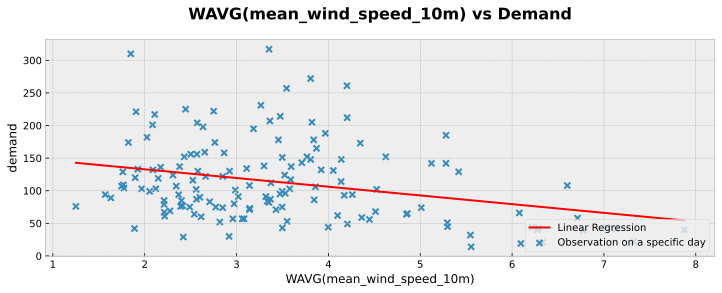

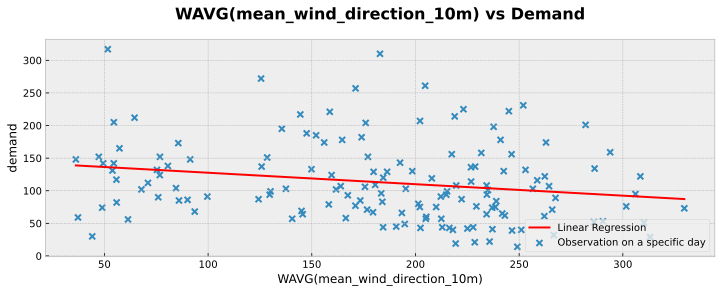

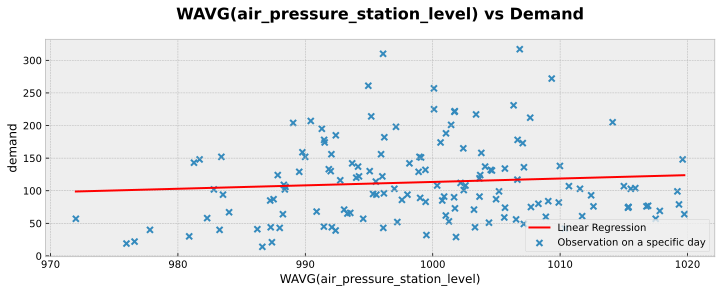

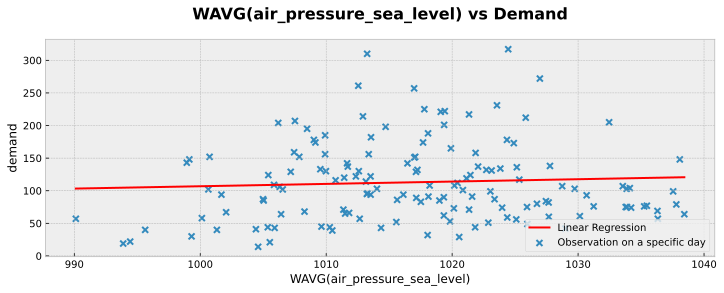

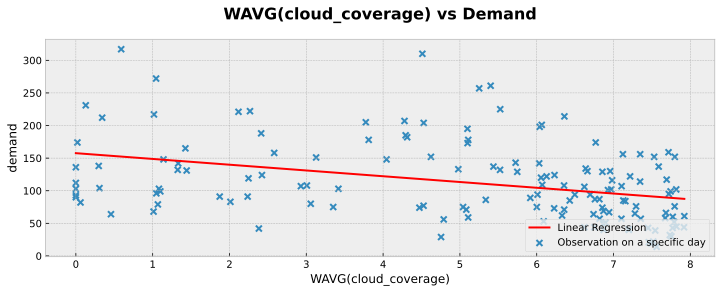

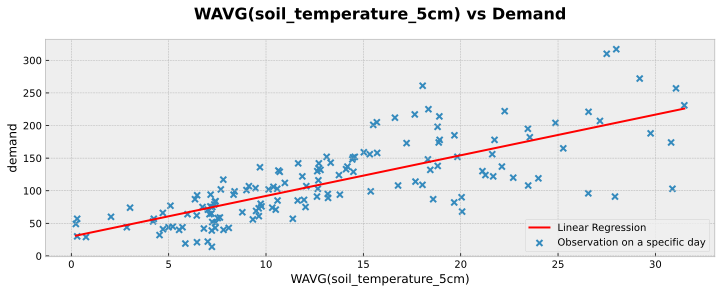

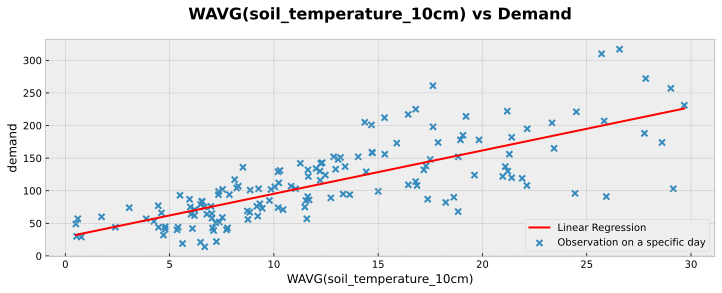

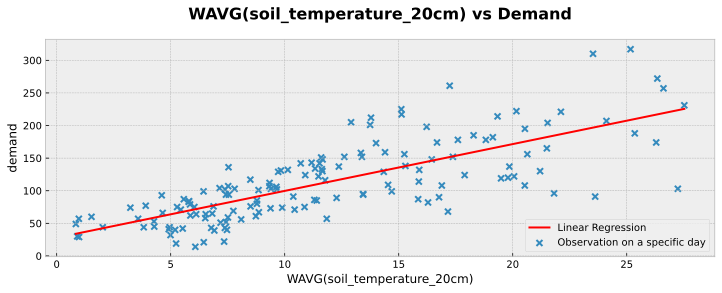

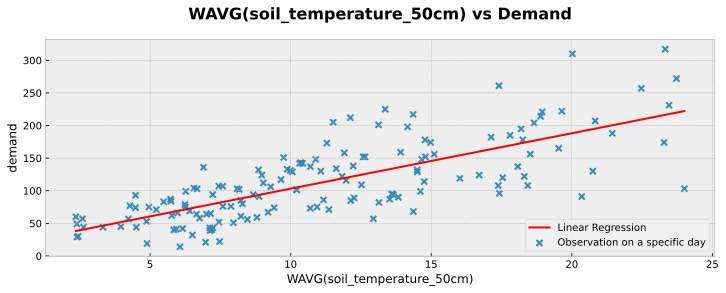

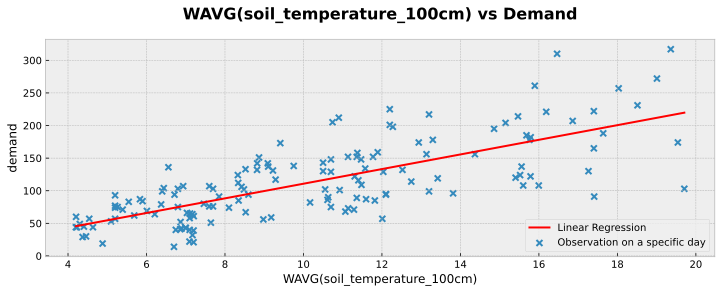

In [13]:
plot_all_features("Essen")

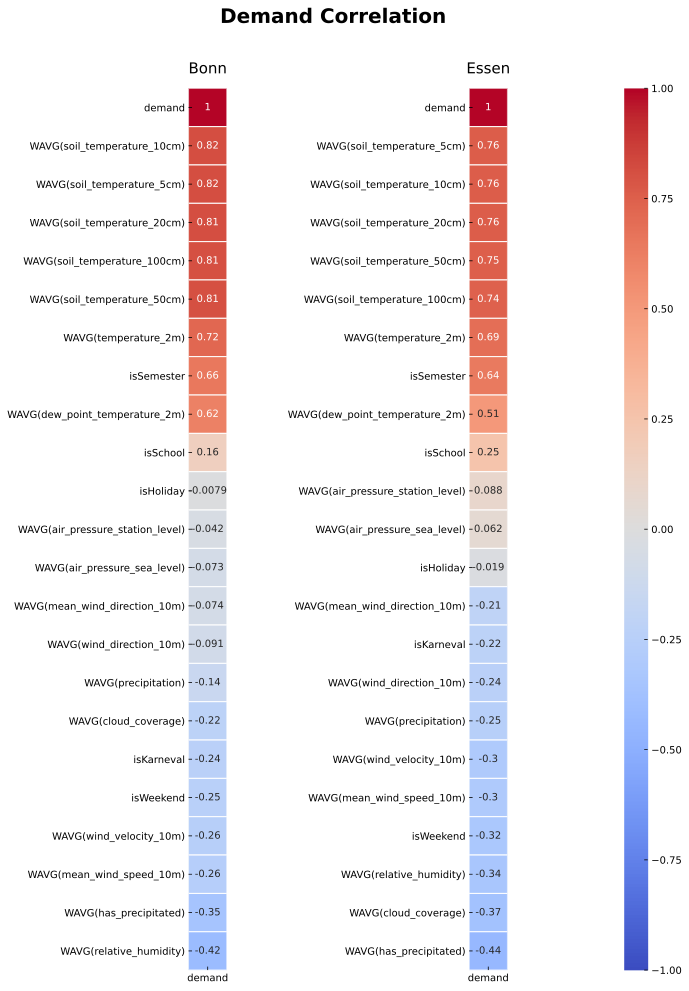

In [14]:
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(10,14))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr()[['demand']].sort_values(by='demand', ascending=False), 
                 annot = True, 
                 fmt='.2g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)

g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr()[['demand']].sort_values(by='demand', ascending=False), 
                 annot = True, 
                 fmt='.2g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_title("Essen", fontsize=15, pad=15)

f.tight_layout()
f.suptitle('Demand Correlation', fontweight="bold", fontsize=20)
f.subplots_adjust(top=0.9)

#plt.savefig('Demand Correlation.png', bbox_inches='tight')
plt.show()

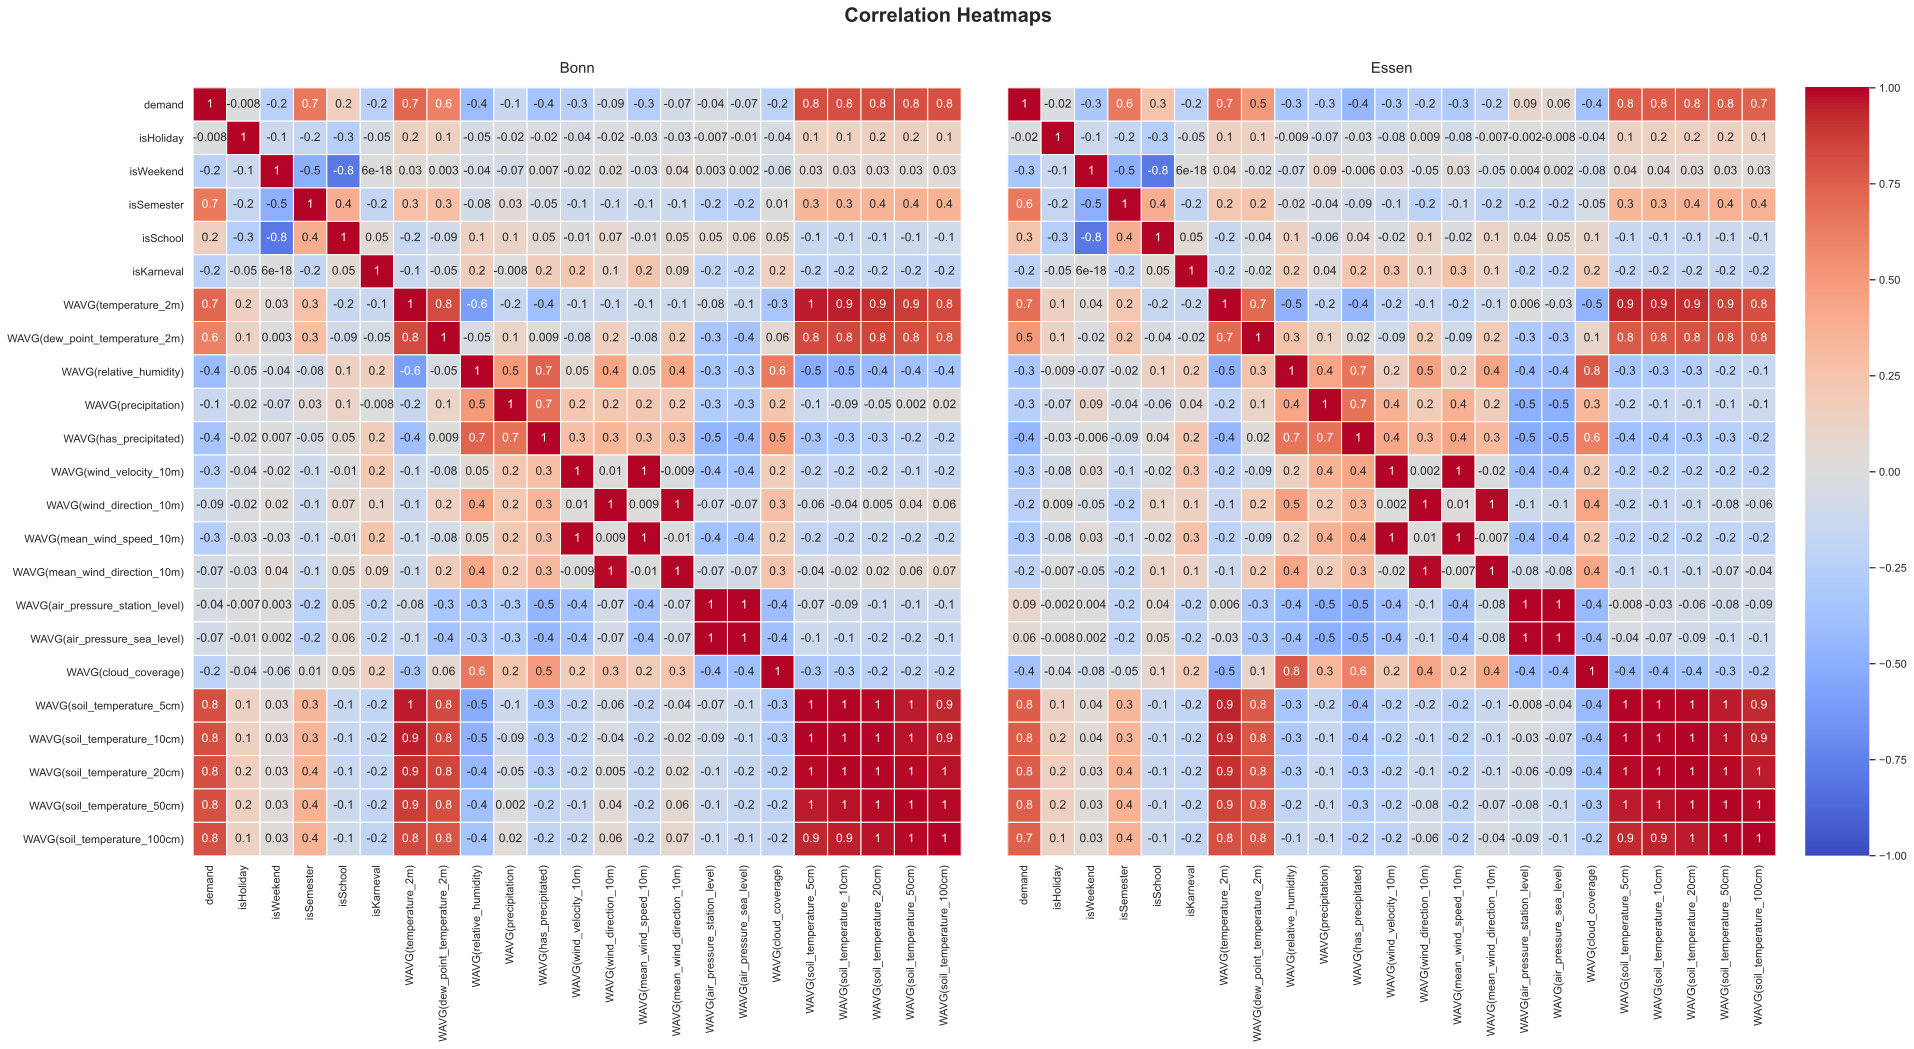

In [15]:
sns.set_theme()
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(27,14))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_title("Essen", fontsize=15, pad=15)

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

f.tight_layout()
f.suptitle('Correlation Heatmaps', fontweight="bold", fontsize=20)
f.subplots_adjust(top=0.9)

#plt.savefig('heatmaps.pdf', bbox_inches='tight')
plt.show()

## Picking features 

In [16]:
all_features = [ 
    'isHoliday',
    'isWeekend', 
    'isSemester', 
    'isSchool',
    'isKarneval', 
    'WAVG(temperature_2m)', 
    'WAVG(dew_point_temperature_2m)',
    'WAVG(relative_humidity)', 
    'WAVG(precipitation)',
    'WAVG(has_precipitated)', 
    'WAVG(wind_velocity_10m)',
    'WAVG(wind_direction_10m)', 
    'WAVG(mean_wind_speed_10m)',
    'WAVG(mean_wind_direction_10m)',
    'WAVG(air_pressure_station_level)',
    'WAVG(air_pressure_sea_level)', 
    'WAVG(cloud_coverage)',
    'WAVG(soil_temperature_5cm)', 
    'WAVG(soil_temperature_10cm)',
    'WAVG(soil_temperature_20cm)', 
    'WAVG(soil_temperature_50cm)',
    'WAVG(soil_temperature_100cm)'
]

features = [
    'isWeekend', 
    'isSemester', 
    'isKarneval', 
    'WAVG(temperature_2m)',  
    'WAVG(precipitation)',
    'WAVG(has_precipitated)', 
    'WAVG(wind_velocity_10m)', 
    'WAVG(mean_wind_speed_10m)',
    'WAVG(soil_temperature_5cm)', 
    'WAVG(soil_temperature_10cm)',
    'WAVG(soil_temperature_20cm)', 
    'WAVG(soil_temperature_50cm)',
    'WAVG(soil_temperature_100cm)'
]

In [17]:
X_bonn, y_bonn = df_bonn[features], df_bonn["demand"]
# Create training, validation and test data:
X_bonn_train, X_bonn_test, y_bonn_train, y_bonn_test = train_test_split(X_bonn, y_bonn, test_size=0.3, random_state=1)
X_bonn_train, X_bonn_val, y_bonn_train, y_bonn_val = train_test_split(X_bonn_train, y_bonn_train, test_size=0.3, random_state=1)

In [18]:
X_essen, y_essen = df_essen[features], df_essen["demand"]
# Create training, validation and test data:
X_essen_train, X_essen_test, y_essen_train, y_essen_test = train_test_split(X_essen, y_essen, test_size=0.3, random_state=1)
X_essen_train, X_essen_val, y_essen_train, y_essen_val = train_test_split(X_essen_train, y_essen_train, test_size=0.3, random_state=1)

In [19]:
X_bonn_train

isWeekend  isSemester  isKarneval  WAVG(temperature_2m)  \
2019-05-30        0.0         0.0         0.0             16.731733   
2019-06-19        0.0         1.0         0.0             23.589706   
2019-03-22        0.0         0.0         0.0             14.082487   
2019-05-02        0.0         1.0         0.0             11.238628   
2019-04-21        1.0         0.0         0.0             18.861799   
...               ...         ...         ...                   ...   
2019-05-03        0.0         1.0         0.0              9.206259   
2019-06-06        0.0         1.0         0.0             14.407424   
2019-03-23        1.0         0.0         0.0              8.150560   
2019-02-12        0.0         0.0         0.0              4.065661   
2019-03-11        0.0         0.0         0.0              4.152241   

            WAVG(precipitation)  WAVG(has_precipitated)  \
2019-05-30             0.000000                0.481101   
2019-06-19             0.237244                0.508468   
2019-03-22             0.000000                0.000000   
2019-05-02             0.341218                0.291220   
2019-04-21             0.000000                0.000000   
...                         ...                     ...   
2019-05-03             0.013384                0.470452   
2019-06-06             0.079804                0.073541   
2019-03-23             0.000000                0.170796   
2019-02-12             0.000000                0.000000   
2019-03-11             0.205350                0.675237   

            WAVG(wind_velocity_10m)  WAVG(mean_wind_speed_10m)  \
2019-05-30                 2.221813                   2.264320   
2019-06-19                 2.624286                   2.766492   
2019-03-22                 2.766384                   2.829159   
2019-05-02                 2.377886                   2.345338   
2019-04-21                 2.088024                   2.068976   
...                             ...                        ...   
2019-05-03                 2.884991                   2.883112   
2019-06-06                 2.177110                   2.142929   
2019-03-23                 1.834466                   1.924421   
2019-02-12                 2.257034                   2.234842   
2019-03-11                 5.237283                   5.202292   

            WAVG(soil_temperature_5cm)  WAVG(soil_temperature_10cm)  \
2019-05-30                   17.550694                    17.134957   
2019-06-19                   25.492465                    24.621860   
2019-03-22                   12.782261                    11.534522   
2019-05-02                   14.943844                    14.210000   
2019-04-21                   18.713520                    17.503434   
...                                ...                          ...   
2019-05-03                   13.049251                    12.973011   
2019-06-06                   18.629400                    19.243699   
2019-03-23                    8.598097                     8.479259   
2019-02-12                    3.324863                     3.346074   
2019-03-11                    4.427286                     4.667325   

            WAVG(soil_temperature_20cm)  WAVG(soil_temperature_50cm)  \
2019-05-30                    16.327957                    15.267344   
2019-06-19                    22.919401                    20.110159   
2019-03-22                     9.182269                     7.538538   
2019-05-02                    12.839484                    11.955595   
2019-04-21                    15.052984                    12.418773   
...                                 ...                          ...   
2019-05-03                    12.566389                    12.084977   
2019-06-06                    20.062084                    19.476319   
2019-03-23                     8.208980                     8.079516   
2019-02-12                     3.322337                     4.405298   
2019-03-11  

---

## Training a Regression Model

In [20]:
# function for plotting
def plot_scikit_output(x, y, model, feature, name, city, label=None):
    min_x, max_x = x.min(), x.max()
    x_space = np.linspace(min_x, max_x, 400)
    color = 'C3' if city=="Bonn" else 'C0'
    # plotting routine
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, marker="x", color='C2')
    plt.plot(x_space, model.predict(x_space.reshape(-1, 1)), color=color, label=label)
    plt.xlabel(feature)
    plt.ylabel("Demand")
    plt.legend()
    plt.title(name, fontsize=16, fontweight="bold", pad=20)
    plt.tight_layout()

### Linear Regression

#### Bonn

In [21]:
lr_bonn = LinearRegression(normalize=True)
lr_bonn.fit(X_bonn_train, y_bonn_train)
# Training R2 score (1.0 is best):
lr_bonn.score(X_bonn_train, y_bonn_train)

0.8940259146381714

In [22]:
# Validation R2 score (1.0 is best):
y_bonn_pred_lr = lr_bonn.predict(X_bonn_val)
lr_bonn.score(X_bonn_val, y_bonn_val)

0.8839074120218474

In [23]:
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_lr))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_lr))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_lr))

MSE: 118642.76571095025
MAE: 246.19723124721133
R2:  0.8839074120218474


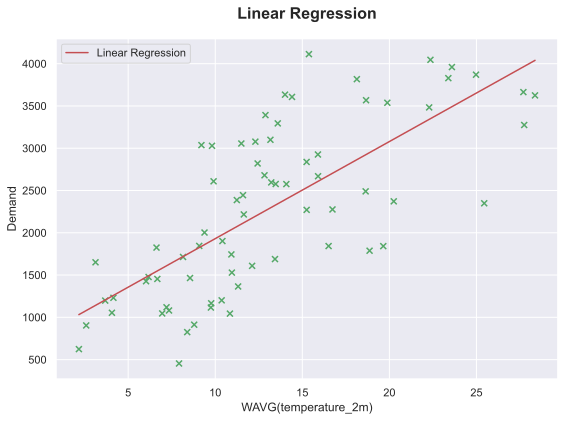

In [24]:
lr_feature = "WAVG(temperature_2m)"
lr_bonn = LinearRegression().fit(X_bonn_train[lr_feature].values.reshape(-1, 1), y_bonn_train)
plot_scikit_output(X_bonn_train[lr_feature], y_bonn_train, lr_bonn, lr_feature, "Linear Regression", "Bonn", "Linear Regression")

#### Essen

In [25]:
lr_essen = LinearRegression(normalize=True)
lr_essen.fit(X_essen_train, y_essen_train)
# Training R2 score (1.0 is best):
lr_essen.score(X_essen_train, y_essen_train)

0.8521090110332077

In [26]:
# Validation R2 score (1.0 is best):
y_essen_pred_lr = lr_essen.predict(X_essen_val)
lr_essen.score(X_essen_val, y_essen_val)

0.7302594764857504

In [27]:
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_lr))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_lr))
print("R2: ", r2_score(y_essen_val, y_essen_pred_lr))

MSE: 1168.7438659751695
MAE: 20.408933304593692
R2:  0.7302594764857504


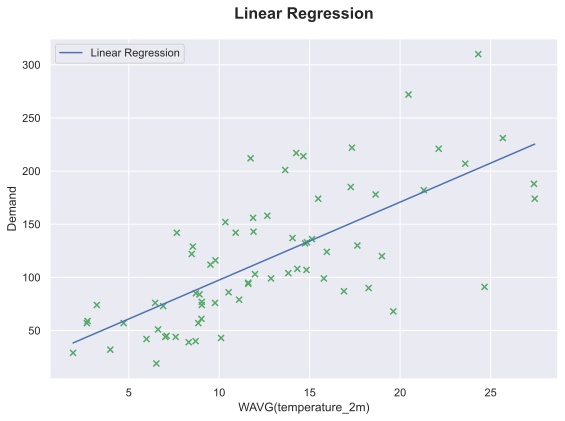

In [28]:
lr_feature = "WAVG(temperature_2m)"
lr_essen = LinearRegression().fit(X_essen_train[lr_feature].values.reshape(-1, 1), y_essen_train)
plot_scikit_output(X_essen_train[lr_feature], y_essen_train, lr_essen, lr_feature, "Linear Regression", "Essen", "Linear Regression")

---

### Tree-Based Regression

#### Bonn   
Which tree depth parameter $\mathrm{depth}$ is optimal?

Text(0.5, 1.0, 'Tree-Based Regression Error Validation')

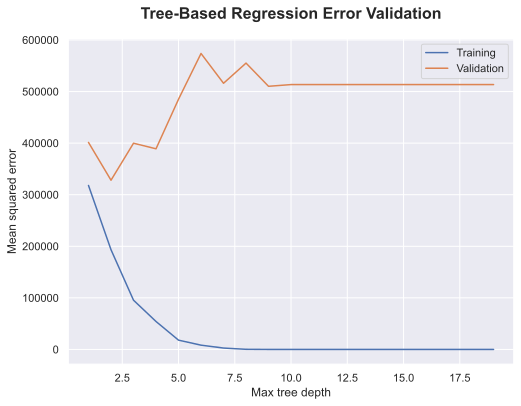

In [29]:
# Search the best tree depth
err_train_tree = []
err_val_tree = []

for depth in range(1, 20):
    # Fit model
    tree_reg_bonn = DecisionTreeRegressor(max_depth=depth, criterion="mse", random_state=1)
    tree_model_bonn = tree_reg_bonn.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_tree.append(mean_squared_error(y_bonn_train, tree_model_bonn.predict(X_bonn_train)))
    err_val_tree.append(mean_squared_error(y_bonn_val, tree_model_bonn.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_tree, range(1, 20), err_val_tree)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Tree-Based Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [30]:
print("Best validation value for", np.argmin(err_val_tree)+1, "max depth")

Best validation value for 2 max depth


Train model with the optimal $\mathrm{depth}$.

In [31]:
# Fit model (for the optimal tree depth)
tree_reg_bonn = DecisionTreeRegressor(max_depth=np.argmin(err_val_tree)+1, criterion="mse", random_state=1)
tree_model_bonn = tree_reg_bonn.fit(X_bonn_train, y_bonn_train)

# Predict
y_bonn_pred_tree = tree_model_bonn.predict(X_bonn_val)

In [32]:
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_tree))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_tree))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_tree))

MSE: 328085.39455301984
MAE: 474.23966954846804
R2:  0.6789666668401176


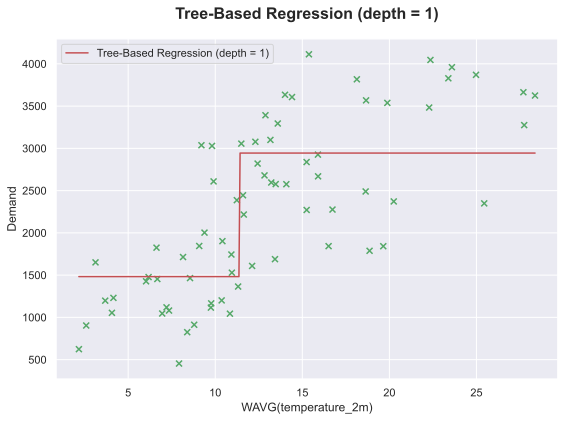

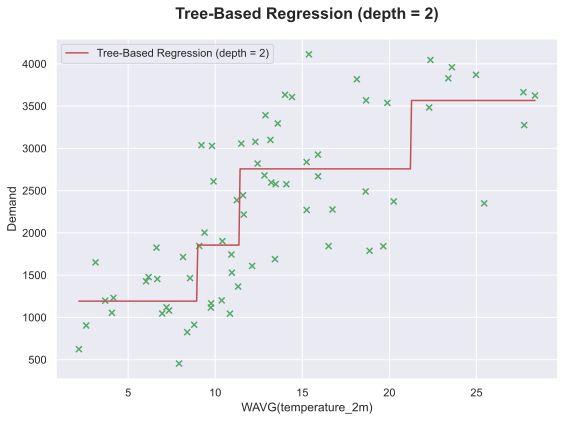

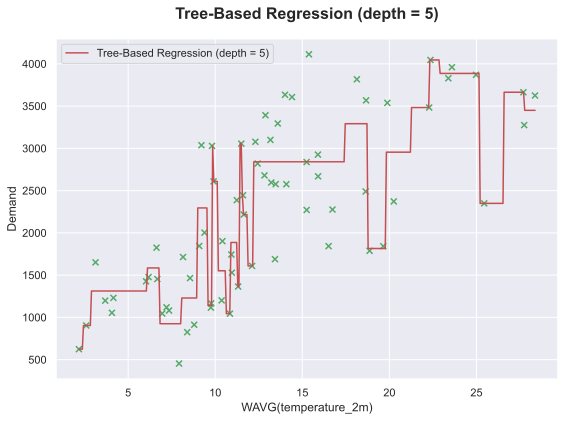

In [33]:
tree_feature = "WAVG(temperature_2m)"
for depth in (1, np.argmin(err_val_tree)+1, 5):
    tree_reg_bonn = DecisionTreeRegressor(max_depth=depth)
    tree_model_bonn = tree_reg_bonn.fit(X_bonn_train[tree_feature].values.reshape(-1, 1), y_bonn_train)
    plot_scikit_output(X_bonn_train[tree_feature], 
                       y_bonn_train, 
                       tree_model_bonn, 
                       tree_feature, 
                       f"Tree-Based Regression (depth = {depth})", 
                       "Bonn", 
                       f"Tree-Based Regression (depth = {depth})")

In [34]:
def plot_regression_tree_sklearn(tree_depth, city):
    
    if city == "Bonn":
        X = X_bonn_train
        y = y_bonn_train
    else:
        X = X_essen_train
        y = y_essen_train

    # Fit regression model
    model = DecisionTreeRegressor(max_depth=tree_depth, random_state=1)
    model.fit(X[tree_feature].values.reshape(-1, 1), y) 
    
    dot_data = export_graphviz(model, feature_names=["WAVG(temperature_2m)"], filled=True, rounded=True)  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

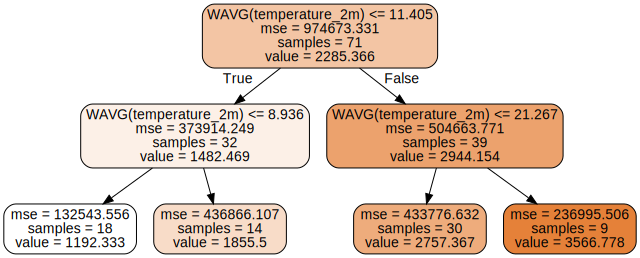

In [35]:
plot_regression_tree_sklearn(np.argmin(err_val_tree)+1, city="Bonn")

#### Essen   
Which tree depth parameter $\mathrm{depth}$ is optimal?

Text(0.5, 1.0, 'Tree-Based Regression Error Validation')

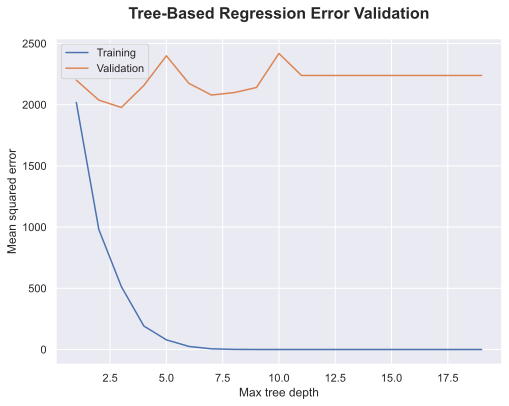

In [36]:
# Search the best tree depth
err_train_tree = []
err_val_tree = []

for depth in range(1, 20):
    # Fit model
    tree_reg_essen = DecisionTreeRegressor(max_depth=depth, criterion="mse", random_state=1)
    tree_model_essen = tree_reg_essen.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_tree.append(mean_squared_error(y_essen_train, tree_model_essen.predict(X_essen_train)))
    err_val_tree.append(mean_squared_error(y_essen_val, tree_model_essen.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_tree, range(1, 20), err_val_tree)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Tree-Based Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [37]:
print("Best validation value for", np.argmin(err_val_tree)+1, "max depth")

Best validation value for 3 max depth


Train model with the optimal $\mathrm{depth}$.

In [38]:
# Fit model (for the optimal tree depth)
tree_reg_essen = DecisionTreeRegressor(max_depth=np.argmin(err_val_tree)+1, criterion="mse", random_state=1)
tree_model_essen = tree_reg_essen.fit(X_essen_train, y_essen_train)

# Predict
y_essen_pred_tree = tree_model_essen.predict(X_essen_val)

In [39]:
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_tree))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_tree))
print("R2: ", r2_score(y_essen_val, y_essen_pred_tree))

MSE: 1977.4440886719703
MAE: 30.98144463063818
R2:  0.5436153127926937


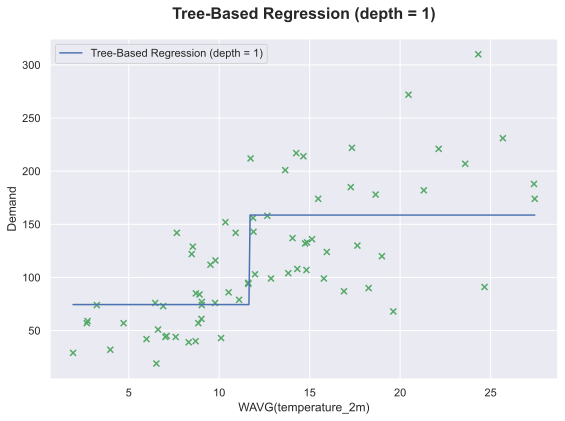

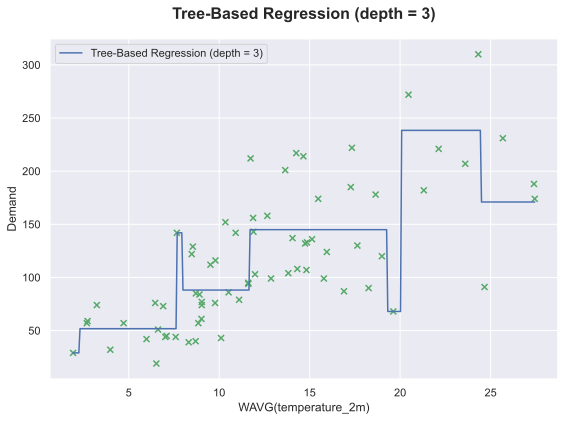

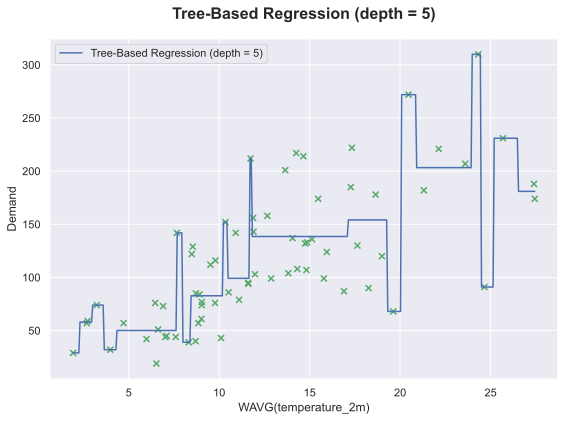

In [40]:
tree_feature = "WAVG(temperature_2m)"
for depth in (1, np.argmin(err_val_tree)+1, 5):
    tree_reg_essen = DecisionTreeRegressor(max_depth=depth)
    tree_model_essen = tree_reg_essen.fit(X_essen_train[tree_feature].values.reshape(-1, 1), y_essen_train)
    plot_scikit_output(X_essen_train[tree_feature], 
                       y_essen_train, 
                       tree_model_essen, 
                       tree_feature, 
                       f"Tree-Based Regression (depth = {depth})", 
                       "Essen", 
                       f"Tree-Based Regression (depth = {depth})")

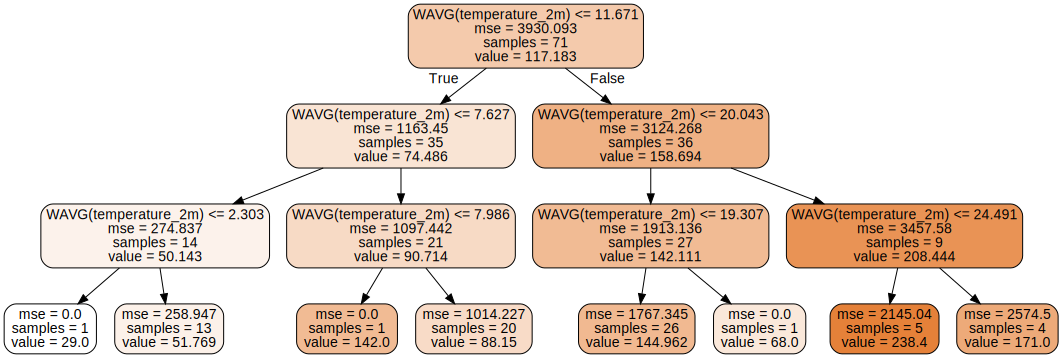

In [41]:
plot_regression_tree_sklearn(np.argmin(err_val_tree)+1, city="Essen")

### Boosting   
Let's test some boosting techniques.

#### AdaBoost

#### Bonn

In [42]:
ada_bonn = AdaBoostRegressor(random_state=1)
ada_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_ada = ada_bonn.predict(X_bonn_val)

In [43]:
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_ada))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_ada))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_ada))

MSE: 247036.03800119364
MAE: 374.98270179524707
R2:  0.758273900616084


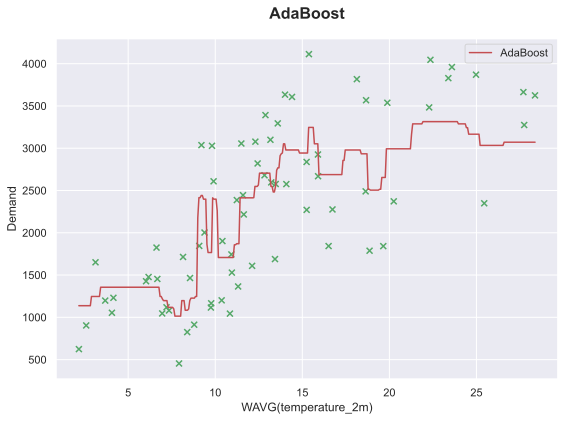

In [44]:
ada_feature = "WAVG(temperature_2m)"
ada_bonn = AdaBoostRegressor(random_state=1).fit(X_bonn_train[ada_feature].values.reshape(-1, 1), y_bonn_train)
plot_scikit_output(X_bonn_train[ada_feature], 
                   y_bonn_train, 
                   ada_bonn, 
                   ada_feature, 
                   "AdaBoost", "Bonn", "AdaBoost")

#### Essen

In [45]:
ada_essen = AdaBoostRegressor(random_state=1)
ada_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_ada = ada_essen.predict(X_essen_val)

In [46]:
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_ada))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_ada))
print("R2: ", r2_score(y_essen_val, y_essen_predict_ada))

MSE: 1426.3069747005907
MAE: 22.94519108357162
R2:  0.6708151364484365


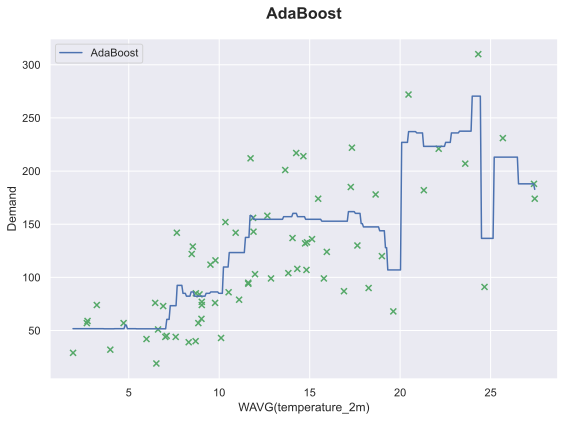

In [47]:
ada_feature = "WAVG(temperature_2m)"
ada_essen = AdaBoostRegressor(random_state=1).fit(X_essen_train[ada_feature].values.reshape(-1, 1), y_essen_train)
plot_scikit_output(X_essen_train[ada_feature], 
                   y_essen_train, 
                   ada_essen, 
                   ada_feature, 
                   "AdaBoost", "Essen", "AdaBoost")

#### Gradient Tree Boosting

#### Bonn

In [48]:
gradient_bonn = GradientBoostingRegressor(random_state=1)
gradient_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_gradient = gradient_bonn.predict(X_bonn_val)

In [49]:
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_gradient))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_gradient))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_gradient))

MSE: 219737.78739866114
MAE: 339.4056394813834
R2:  0.7849853864848905


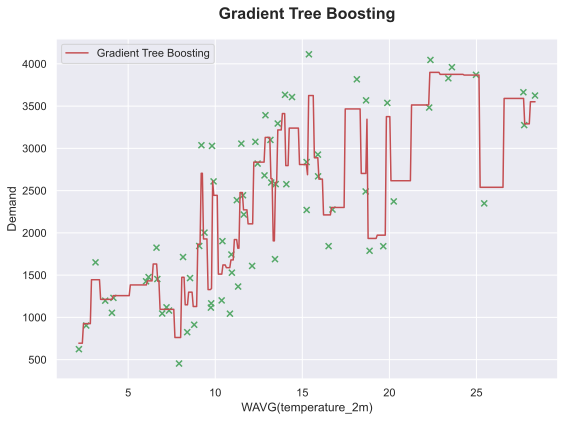

In [50]:
gradient_feature = "WAVG(temperature_2m)"
gradient_bonn = GradientBoostingRegressor(random_state=1).fit(X_bonn_train[gradient_feature].values.reshape(-1, 1), 
                                                              y_bonn_train)
plot_scikit_output(X_bonn_train[gradient_feature], 
                   y_bonn_train, 
                   gradient_bonn, 
                   gradient_feature, 
                   "Gradient Tree Boosting", "Bonn", "Gradient Tree Boosting")

#### Essen

In [51]:
gradient_essen = GradientBoostingRegressor(random_state=1)
gradient_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_gradient = gradient_essen.predict(X_essen_val)

In [52]:
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_gradient))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_gradient))
print("R2: ", r2_score(y_essen_val, y_essen_predict_gradient))

MSE: 1366.9883612529372
MAE: 21.172953427049524
R2:  0.6845055902008153


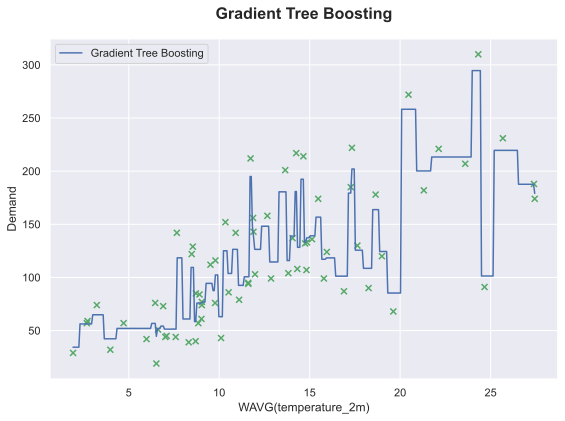

In [53]:
gradient_feature = "WAVG(temperature_2m)"
gradient_essen = GradientBoostingRegressor(random_state=1).fit(X_essen_train[gradient_feature].values.reshape(-1, 1), 
                                                               y_essen_train)
plot_scikit_output(X_essen_train[gradient_feature], 
                   y_essen_train, 
                   gradient_essen, 
                   gradient_feature, 
                   "Gradient Tree Boosting", "Essen", "Gradient Tree Boosting")

### Bagging

#### Bonn

In [54]:
bagging_bonn =  BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion="mse", random_state=1), 
                                 random_state=1)
bagging_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_bagging = bagging_bonn.predict(X_bonn_val)

In [55]:
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_bagging))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_bagging))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_bagging))

MSE: 217393.86000000002
MAE: 352.6516129032257
R2:  0.7872789321226112


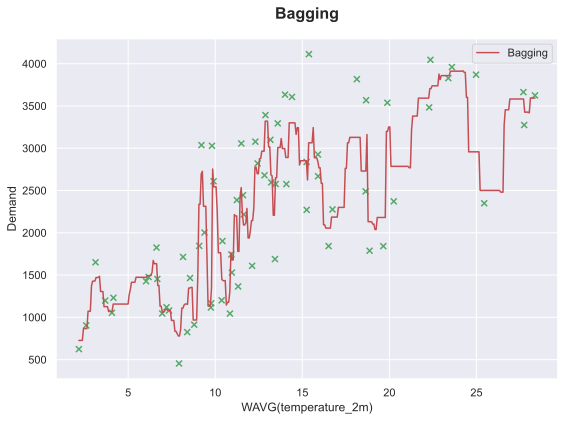

In [56]:
bagging_feature = "WAVG(temperature_2m)"
bagging_bonn = BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion="mse", random_state=1), 
                                random_state=1).fit(X_bonn_train[bagging_feature].values.reshape(-1, 1), 
                                                    y_bonn_train)
plot_scikit_output(X_bonn_train[bagging_feature], 
                   y_bonn_train, 
                   bagging_bonn, 
                   bagging_feature, 
                   "Bagging", "Bonn", "Bagging")

#### Essen

In [57]:
bagging_essen =  BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion="mse", random_state=1), 
                              random_state=1)
bagging_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_bagging = bagging_essen.predict(X_essen_val)

In [58]:
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_bagging))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_bagging))
print("R2: ", r2_score(y_essen_val, y_essen_predict_bagging))

MSE: 1298.3087096774195
MAE: 22.693548387096772
R2:  0.7003565270143309


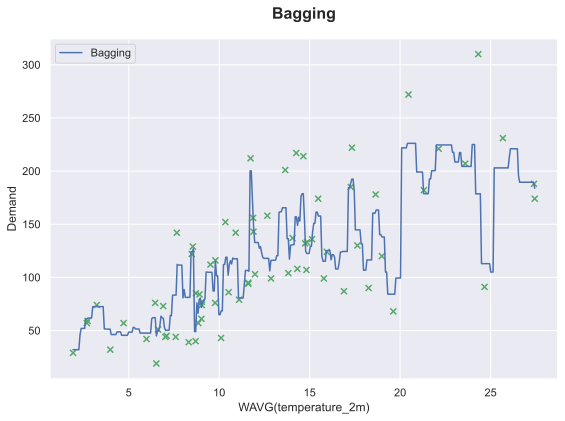

In [59]:
bagging_feature = "WAVG(temperature_2m)"
bagging_essen = BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion="mse", random_state=1), 
                                random_state=1).fit(X_essen_train[bagging_feature].values.reshape(-1, 1), 
                                                    y_essen_train)
plot_scikit_output(X_essen_train[bagging_feature], 
                   y_essen_train, 
                   bagging_essen, 
                   bagging_feature, 
                   "Bagging", "Essen", "Bagging")

### Random Forest

#### Bonn

Text(0.5, 1.0, 'Random Forrest Error Validation')

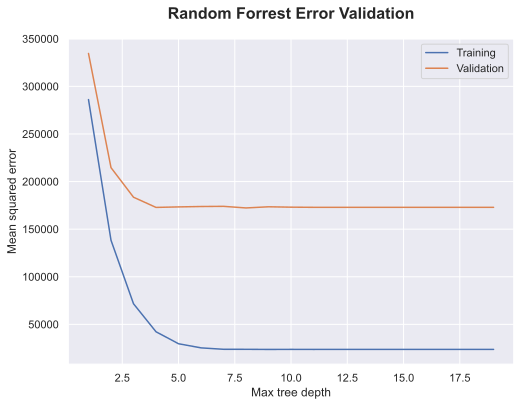

In [60]:
err_train_rf_bonn = []
err_val_rf_bonn = []

for depth in range(1, 20):
    # Fit model
    rf_regressor = RandomForestRegressor(n_estimators=1000, 
                                         bootstrap=True, # we select boostrapp, i.e. we use bagging
                                         random_state=1,
                                         max_depth=depth,
                                         criterion="mse") 
    rf_model = rf_regressor.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_rf_bonn.append(mean_squared_error(y_bonn_train, rf_model.predict(X_bonn_train)))
    err_val_rf_bonn.append(mean_squared_error(y_bonn_val, rf_model.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_rf_bonn, range(1, 20), err_val_rf_bonn)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Random Forrest Error Validation", fontsize=16, fontweight="bold", pad=20)

In [61]:
print("Best validation value for", np.argmin(err_val_rf_bonn)+1, "max depth")

Best validation value for 8 max depth


In [62]:
# sepcify and fit model

rf_regressor_bonn = RandomForestRegressor(n_estimators=1000, 
                                          bootstrap=True, # we select boostrapp, i.e. we use bagging
                                          random_state=1,
                                          max_depth=4, # selecting the second best depth to reduce complexity
                                          criterion="mse") 
rf_model_bonn = rf_regressor_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_rf = rf_model_bonn.predict(X_bonn_val)

In [63]:
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_rf))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_rf))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_rf))

MSE: 172854.37731760248
MAE: 327.0425304769564
R2:  0.830861056838121


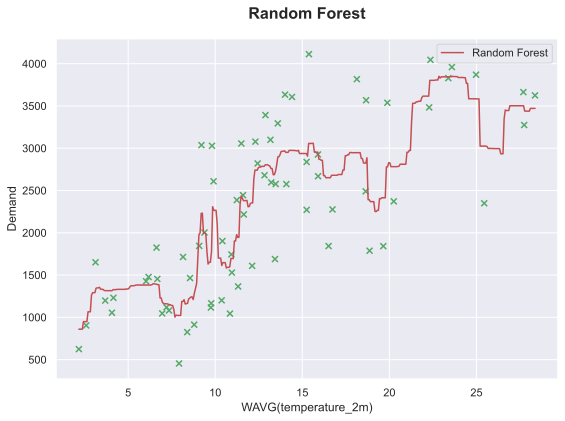

In [64]:
rf_feature = "WAVG(temperature_2m)"
rf_model_bonn = RandomForestRegressor(n_estimators=1000, 
                                      bootstrap=True, # we select boostrapp, i.e. we use bagging
                                      random_state=1,
                                      max_depth=4, # selecting the second best depth to reduce complexity
                                      criterion="mse").fit(X_bonn_train[rf_feature].values.reshape(-1, 1), 
                                                           y_bonn_train)
plot_scikit_output(X_bonn_train[rf_feature], 
                   y_bonn_train, 
                   rf_model_bonn, 
                   rf_feature, 
                   "Random Forest", 
                   "Bonn", 
                   "Random Forest")

#### Essen

Text(0.5, 1.0, 'Random Forrest Error Validation')

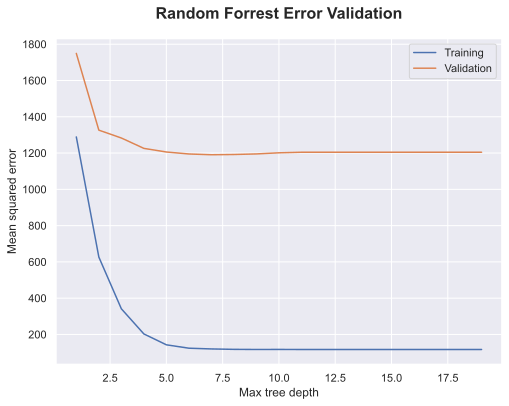

In [65]:
err_train_rf_essen = []
err_val_rf_essen = []

for depth in range(1, 20):
    # Fit model
    rf_regressor = RandomForestRegressor(n_estimators=1000, 
                                         bootstrap=True, # we select boostrapp, i.e. we use bagging
                                         random_state=1,
                                         max_depth=depth,
                                         criterion="mse") 
    rf_model = rf_regressor.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_rf_essen.append(mean_squared_error(y_essen_train, rf_model.predict(X_essen_train)))
    err_val_rf_essen.append(mean_squared_error(y_essen_val, rf_model.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_rf_essen, range(1, 20), err_val_rf_essen)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Random Forrest Error Validation", fontsize=16, fontweight="bold", pad=20)

In [66]:
print("Best validation value for", np.argmin(err_val_rf_essen)+1, "max depth")

Best validation value for 7 max depth


In [67]:
# sepcify and fit model

rf_regressor_essen = RandomForestRegressor(n_estimators=1000, 
                                           bootstrap=True, # we select boostrapp, i.e. we use bagging
                                           random_state=1,
                                           max_depth=np.argmin(err_val_rf_essen)+1,
                                           criterion="mse") 
rf_model_essen = rf_regressor_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_rf = rf_model_essen.predict(X_essen_val)

In [68]:
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_rf))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_rf))
print("R2: ", r2_score(y_essen_val, y_essen_predict_rf))

MSE: 1190.7397070755565
MAE: 20.166258772231348
R2:  0.7251829410135371


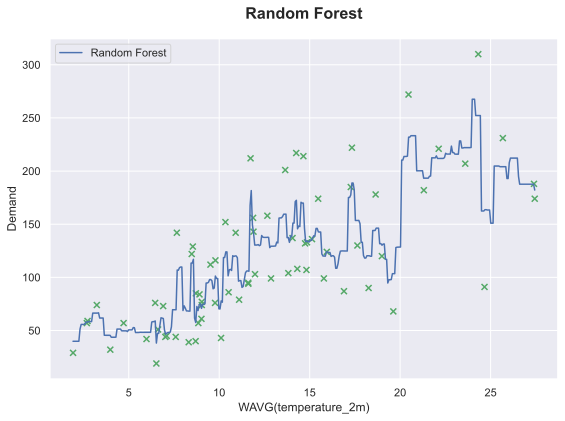

In [69]:
rf_feature = "WAVG(temperature_2m)"
rf_model_essen = RandomForestRegressor(n_estimators=1000, 
                                       bootstrap=True, # we select boostrapp, i.e. we use bagging
                                       random_state=1,
                                       max_depth=np.argmin(err_val_rf_essen)+1, 
                                       criterion="mse").fit(X_essen_train[rf_feature].values.reshape(-1, 1), 
                                                           y_essen_train)
plot_scikit_output(X_essen_train[rf_feature], 
                   y_essen_train, 
                   rf_model_essen, 
                   rf_feature, 
                   "Random Forest", 
                   "Essen", 
                   "Random Forest")

### RBF Regression

#### Bonn

In [70]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_bonn_train_sc = sc_X.fit_transform(X_bonn_train)
y_bonn_train_sc = sc_y.fit_transform(y_bonn_train.values.reshape(-1, 1))
X_bonn_val_sc = sc_X.fit_transform(X_bonn_val)
y_bonn_val_sc = sc_y.fit_transform(y_bonn_val.values.reshape(-1, 1))

# RBF regression
from sklearn.svm import SVR

rbf_regressor_bonn = SVR(kernel='rbf', gamma=0.01)
rbf_regressor_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)
y_bonn_predict_rbf = sc_y.inverse_transform(rbf_regressor_bonn.predict(X_bonn_val_sc))

In [71]:
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_rbf))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_rbf))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_rbf))

MSE: 129105.64565475678
MAE: 283.4277330498878
R2:  0.8736694274038852


Text(0.5, 1.0, 'RBF Regression')

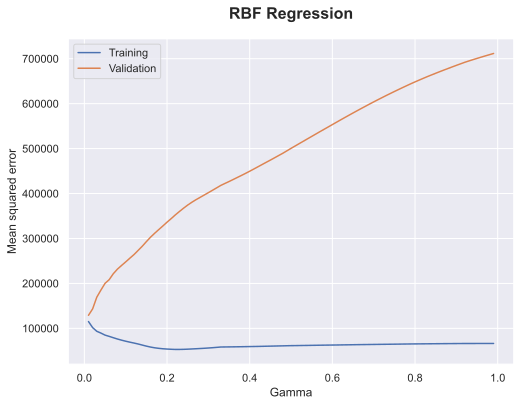

In [72]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X_bonn_train_sc = sc_X.fit_transform(X_bonn_train)
y_bonn_train_sc = sc_y.fit_transform(y_bonn_train.values.reshape(-1, 1))
X_bonn_val_sc = sc_X.fit_transform(X_bonn_val)
y_bonn_val_sc = sc_y.fit_transform(y_bonn_val.values.reshape(-1, 1))

err_train_rbf_bonn = []
err_val_rbf_bonn = []

for gamma in np.arange(0.01, 1, 0.01):
    # Fit model
    rbf_regressor_bonn = SVR(kernel='rbf', gamma=gamma)
    rbf_model_bonn = rbf_regressor_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)
    
    # Compute errors
    err_train_rbf_bonn.append(mean_squared_error(y_bonn_train, sc_y.inverse_transform(rbf_model_bonn.predict(X_bonn_train_sc))))
    err_val_rbf_bonn.append(mean_squared_error(y_bonn_val, sc_y.inverse_transform(rbf_model_bonn.predict(X_bonn_val_sc))))
                           
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0.01, 1, 0.01), err_train_rbf_bonn, np.arange(0.01, 1, 0.01), err_val_rbf_bonn)
plt.legend(["Training", "Validation"])
plt.xlabel("Gamma")
plt.ylabel("Mean squared error")
plt.title("RBF Regression", fontsize=16, fontweight="bold", pad=20)

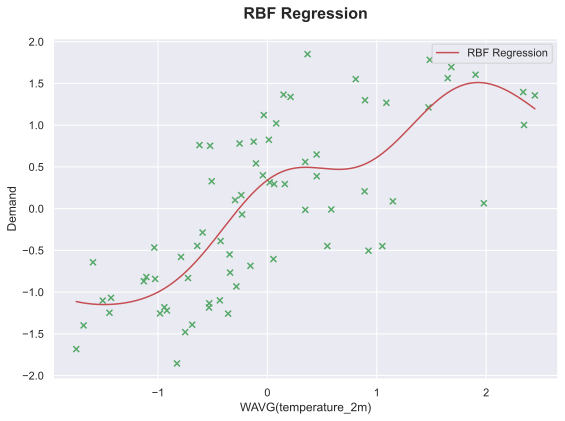

In [73]:
rbf_feature = "WAVG(temperature_2m)"
rbf_regressor_bonn = SVR(kernel='rbf')

sc_X = StandardScaler()
sc_y = StandardScaler()
X_bonn_train_sc = sc_X.fit_transform(X_bonn_train[rbf_feature].values.reshape(-1, 1))
y_bonn_train_sc = sc_y.fit_transform(y_bonn_train.values.reshape(-1, 1))

rbf_model_bonn = rbf_regressor_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)
plot_scikit_output(X_bonn_train_sc, 
                   y_bonn_train_sc, 
                   rbf_model_bonn, 
                   rbf_feature, 
                   "RBF Regression", 
                   "Bonn", 
                   "RBF Regression")

### K-Nearest-Neighbor (KNN) Regression

#### Bonn

Which number of neighbors $k$ is optimal?

Text(0.5, 1.0, 'KNN Regression Error Validation')

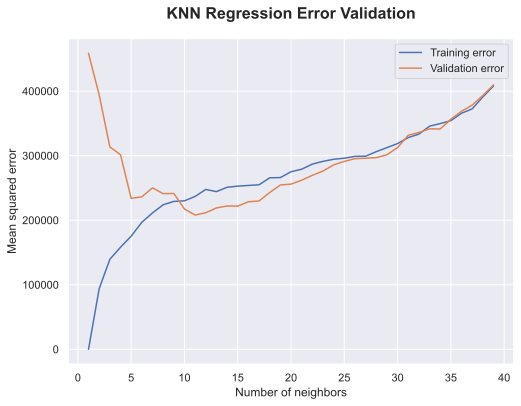

In [74]:
# Search the best number of neighbors
err_train_knn_bonn = [] 
err_val_knn_bonn = []

for k in range(1, 40):

    # Fit model
    KNN_reg = KNeighborsRegressor(n_neighbors=k)
    KNN_model = KNN_reg.fit(X_bonn_train, y_bonn_train)

    # Compute errors
    err_train_knn_bonn.append(mean_squared_error(y_bonn_train, KNN_model.predict(X_bonn_train)))
    err_val_knn_bonn.append(mean_squared_error(y_bonn_val, KNN_model.predict(X_bonn_val)))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 40), err_train_knn_bonn, label="Training error")
plt.plot(range(1, 40), err_val_knn_bonn, label="Validation error")
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Mean squared error")
plt.title("KNN Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [75]:
print("Best validation value for", np.argmin(err_val_knn_bonn)+1, "neighbors")

Best validation value for 11 neighbors


Train model with optimal $k$.

In [77]:
# Fit model (for the optimal number of neighbors)
KNN_reg_bonn = KNeighborsRegressor(n_neighbors=np.argmin(err_val_knn_bonn)+1)
KNN_model_bonn = KNN_reg_bonn.fit(X_bonn_train, y_bonn_train)

# Predict
y_bonn_pred_knn = KNN_model_bonn.predict(X_bonn_val)

In [78]:
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_knn))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_knn))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_knn))

MSE: 207988.74033591044
MAE: 341.7390029325512
R2:  0.7964818925855228


Plot for a single feature:

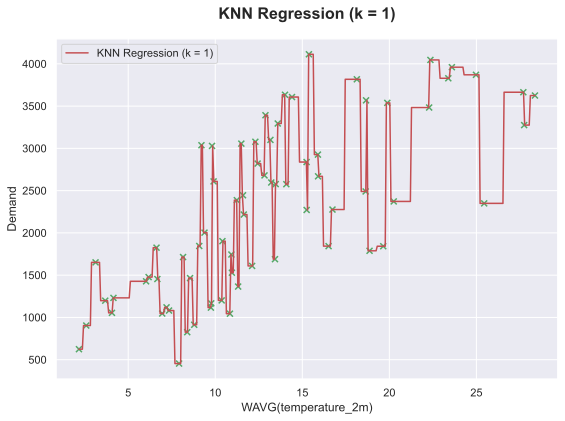

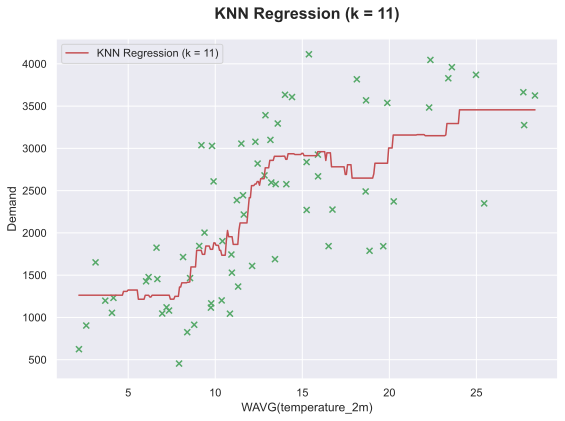

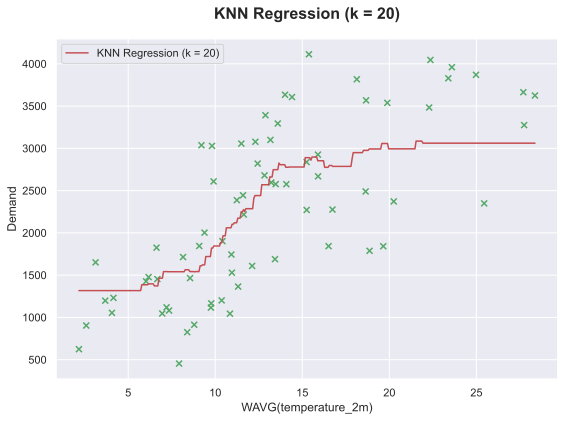

In [85]:
knn_feature = "WAVG(temperature_2m)"
for k in (1, np.argmin(err_val_knn_bonn)+1, 20):
    KNN_reg_bonn = KNeighborsRegressor(n_neighbors=k)
    KNN_model_bonn = KNN_reg_bonn.fit(X_bonn_train[knn_feature].values.reshape(-1, 1), y_bonn_train)
    plot_scikit_output(X_bonn_train[knn_feature], 
                       y_bonn_train, 
                       KNN_model_bonn, 
                       knn_feature, 
                       f"KNN Regression (k = {k})",
                       "Bonn",
                       f"KNN Regression (k = {k})")

#### Essen

Which number of neighbors $k$ is optimal?

Text(0.5, 1.0, 'KNN Regression Error Validation')

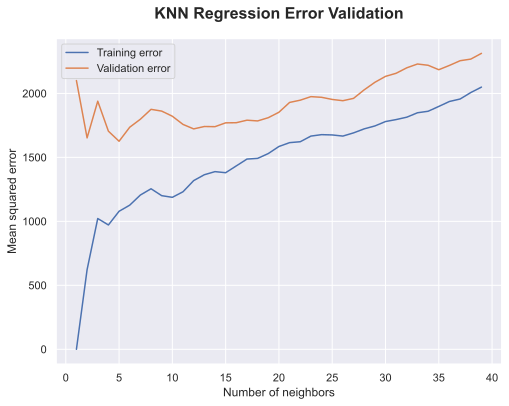

In [86]:
# Search the best number of neighbors
err_train_knn_essen = [] 
err_val_knn_essen = []

for k in range(1, 40):

    # Fit model
    KNN_reg = KNeighborsRegressor(n_neighbors=k)
    KNN_model = KNN_reg.fit(X_essen_train, y_essen_train)

    # Compute errors
    err_train_knn_essen.append(mean_squared_error(y_essen_train, KNN_model.predict(X_essen_train)))
    err_val_knn_essen.append(mean_squared_error(y_essen_val, KNN_model.predict(X_essen_val)))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 40), err_train_knn_essen, label="Training error")
plt.plot(range(1, 40), err_val_knn_essen, label="Validation error")
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Mean squared error")
plt.title("KNN Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [88]:
print("Best validation value for", np.argmin(err_val_knn_essen)+1, "neighbors")

Best validation value for 5 neighbors


Train model with optimal $k$.

In [96]:
# Fit model (for the optimal number of neighbors)
KNN_reg_essen = KNeighborsRegressor(n_neighbors=np.argmin(err_val_knn_essen)+1)
KNN_model_essen = KNN_reg_essen.fit(X_essen_train, y_essen_train)

# Predict
y_essen_pred_knn = KNN_model_essen.predict(X_essen_val)

In [97]:
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_knn))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_knn))
print("R2: ", r2_score(y_essen_val, y_essen_pred_knn))

MSE: 1626.201290322581
MAE: 29.445161290322584
R2:  0.6246804794777159


Plot for a single feature:

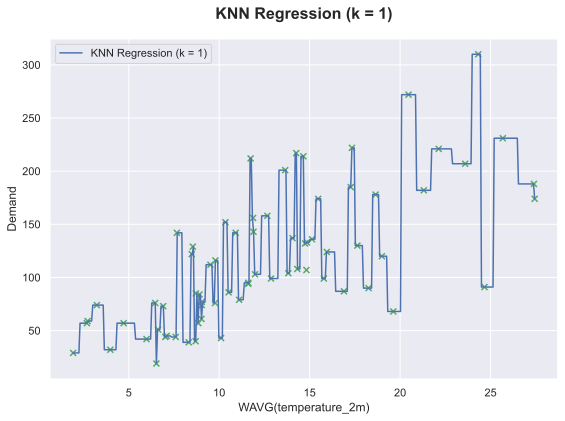

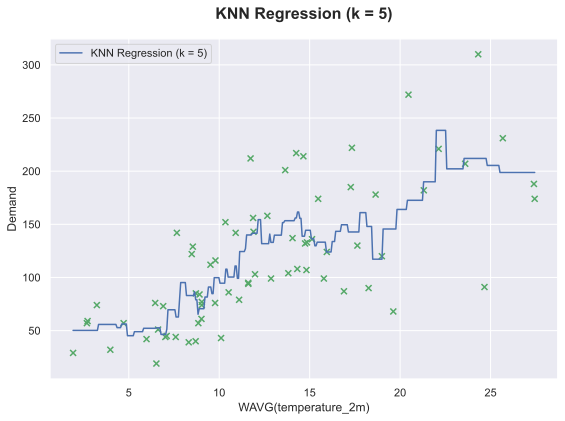

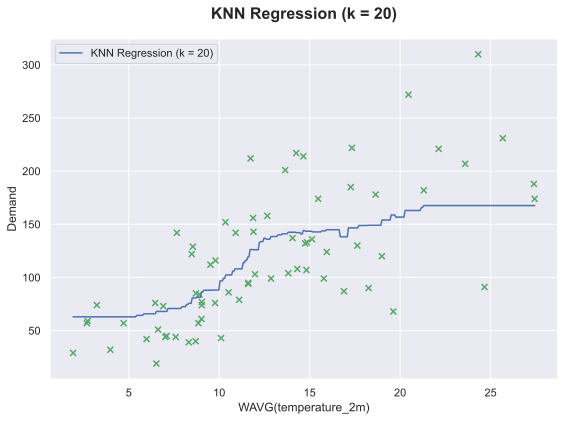

In [98]:
knn_feature = "WAVG(temperature_2m)"
for k in (1, np.argmin(err_val_knn_essen)+1, 20):
    KNN_reg_essen = KNeighborsRegressor(n_neighbors=k)
    KNN_model_essen = KNN_reg_essen.fit(X_essen_train[knn_feature].values.reshape(-1, 1), y_essen_train)
    plot_scikit_output(X_essen_train[knn_feature], 
                       y_essen_train, 
                       KNN_model_essen, 
                       knn_feature, 
                       f"KNN Regression (k = {k})",
                       "Essen",
                       f"KNN Regression (k = {k})")

---

## Experiment: Which subset of features produces the optimal model?  
We asked ourselves the question what would be the best feature selection we could have chosen. To find out we iterated over all possible feature subsets and validated them on a simple linear regression model. For the sake of simplicity we performed this experiment only for the dataset of Bonn.

In [68]:
# Features we picked for examination
# If we pick all_features, there are 22 features => 2**18=4.194.304 possible subsets 
# Careful: Picking all features leads to a long algorithm runtime!!
relevant_features = [ 
    'isHoliday',
    'isWeekend', 
    'isSemester', 
    'isSchool',
    'isKarneval', 
    'WAVG(temperature_2m)', 
    'WAVG(dew_point_temperature_2m)',
    'WAVG(relative_humidity)', 
    'WAVG(precipitation)',
    'WAVG(has_precipitated)', 
    'WAVG(wind_velocity_10m)',
    'WAVG(wind_direction_10m)', 
    'WAVG(mean_wind_speed_10m)',
    'WAVG(mean_wind_direction_10m)',
    'WAVG(air_pressure_station_level)',
    'WAVG(air_pressure_sea_level)', 
    'WAVG(cloud_coverage)',
    'WAVG(soil_temperature_5cm)', 
    'WAVG(soil_temperature_10cm)',
    'WAVG(soil_temperature_20cm)', 
    'WAVG(soil_temperature_50cm)',
    'WAVG(soil_temperature_100cm)'
]

def powerset(s):
    p = (combinations(s, r) for r in range(1,len(s)+1)) 
    p = chain.from_iterable(p)
    p = list(p)
    return p

In [26]:
%%time
# Create training and validation data:
X, y = df_bonn.drop("demand", axis=1), df_bonn["demand"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

score_val_feature_sets = dict()

for feature_set in tqdm(powerset(relevant_features)):   
    feature_set = list(feature_set)
    # Evaluate this feature set by fitting linear regression and calculating the score using validation data
    # => Optimal with respect to simple linear regression model.
    # We could also optimize a regularized linear regression model or even linear regression model on non-linear data.
    lr = LinearRegression(normalize=True).fit(X_train[feature_set], y_train)
    score = lr.score(X_val[feature_set], y_val)
    score_val_feature_sets[", ".join(feature_set)] = score

scores = pd.DataFrame(score_val_feature_sets.values(), index=score_val_feature_sets.keys())
scores = scores.sort_values(0, ascending=False)
scores["len"] = scores.index.map(lambda s: len(s.split(","))) # how big is the subset (relevant_features has length 20)
scores = scores.reset_index()
scores = scores.rename(columns={0: "score", "index": "feature_set"})
scores


CPU times: user 18h 8min 56s, sys: 20min 2s, total: 18h 28min 59s
Wall time: 4h 37min 6s


feature_set     score  len
0        isWeekend, isSemester, isKarneval, WAVG(temper...  0.874316   12
1        isWeekend, isSemester, isKarneval, WAVG(temper...  0.874308   11
2        isWeekend, isSemester, isKarneval, WAVG(temper...  0.874186   12
3        isWeekend, isSemester, isKarneval, WAVG(temper...  0.873956   13
4        isWeekend, isSemester, isKarneval, WAVG(temper...  0.873942   14
...                                                    ...       ...  ...
4194298  isWeekend, isSchool, WAVG(mean_wind_direction_... -0.321735    5
4194299  isHoliday, isWeekend, WAVG(air_pressure_statio... -0.321918    4
4194300  isWeekend, WAVG(mean_wind_direction_10m), WAVG... -0.322368    4
4194301  isHoliday, isWeekend, WAVG(wind_direction_10m)... -0.323555    5
4194302  isHoliday, isWeekend, WAVG(mean_wind_direction... -0.325447    5

[4194303 rows x 3 columns]

In [138]:
optimal_features = scores.loc[0, "feature_set"].split(", ")
optimal_features

['isWeekend',
 'isSemester',
 'isKarneval',
 'WAVG(temperature_2m)',
 'WAVG(dew_point_temperature_2m)',
 'WAVG(has_precipitated)',
 'WAVG(wind_velocity_10m)',
 'WAVG(mean_wind_speed_10m)',
 'WAVG(soil_temperature_5cm)',
 'WAVG(soil_temperature_10cm)',
 'WAVG(soil_temperature_20cm)',
 'WAVG(soil_temperature_50cm)']

Which features are in each feature set of the top 100?

In [68]:
for i in range(101):
    optimal_features.append(scores.loc[i, "feature_set"].split(","))
    optimal_features[i] = [feature.strip() for feature in optimal_features[i]]
    
matches = optimal_features[0]
for i in range(1,101):
    matches = set(matches) & set(optimal_features[i])
       
matches

{'WAVG(has_precipitated)',
 'WAVG(soil_temperature_10cm)',
 'WAVG(soil_temperature_20cm)',
 'WAVG(soil_temperature_50cm)',
 'WAVG(soil_temperature_5cm)',
 'isSemester',
 'isWeekend'}

---